# Import libs and data

In [1]:
import matplotlib.pyplot as plt
from collections import Counter
import re
import pandas as pd
from tinydb import TinyDB, Query
from config import *

In [2]:
db = TinyDB(DB_FILE)
processed_table = db.table(TABLE_PROCESSED)

In [3]:
data = processed_table.all() 
df = pd.DataFrame(data)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3681 entries, 0 to 3680
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              3678 non-null   object 
 1   min_salary         139 non-null    float64
 2   max_salary         161 non-null    float64
 3   salary_currency    196 non-null    object 
 4   minimum_education  3681 non-null   object 
 5   languages          3681 non-null   object 
 6   experience         2168 non-null   float64
 7   responsibilities   3681 non-null   object 
 8   hard_skills        3681 non-null   object 
 9   soft_skills        3681 non-null   object 
 10  certifications     3680 non-null   object 
 11  benefits           3679 non-null   object 
 12  city               1129 non-null   object 
 13  country            1638 non-null   object 
 14  company_name       3678 non-null   object 
 15  company_size       3274 non-null   object 
 16  employment_type    3664 

title  min_salary  max_salary salary_currency minimum_education  \
0  dotnet developer         NaN         NaN            None              none   
1  golang developer         NaN         NaN            None              none   
2     1c programmer         NaN         NaN            None          bachelor   
3     ios developer         NaN         NaN            None       unspecified   
4   devops engineer         NaN         NaN            None              none   

  languages  experience                                   responsibilities  \
0      [ro]         2.0                                                 []   
1      [en]         3.0  [traffic processing, ensure stability, design ...   
2  [ro, ru]         1.0                                                 []   
3  [ro, ru]         1.0  [develop, maintain, optimize, collaborate, debug]   
4      [en]         3.0  [analyze, design, develop, build, test, deploy...   

                                         hard_skills  \
0                                           [dotnet]   
1  [golang, http, https, multithreading, sql, gra...   
2                                               [1c]   
3  [swift, swiftui, cocoapods, git, oop, mvc, mvv...   
4  [aws, amazon cloudwatch, azure, cicd, docker, ...   

                   soft_skills  ... company_size employment_type  \
0                           []  ...         None       full-time   
1  [teamwork, problem solving]  ...         None       full-time   
2                           []  ...         None       full-time   
3                           []  ...         None       full-time   
4                           []  ...         None       full-time   

  work_schedule contract_type remote_work job_categories        date  \
0          None          None     on-site  [programming]  30/05/2025   
1      flexible     permanent      hybrid  [programming]  30/05/2025   
2      standard     permanent     on-site  [programming]  30/05/2025   
3      standard     permanent     on-site  [programming]  30/05/2025   
4      standard     permanent     on-site  [programming]  30/05/2025   

      source                                        occurrences  \
0  robota.md  [02/06/2025, 04/06/2025, 30/05/2025, 06/06/202...   
1  robota.md   [02/06/2025, 30/05/2025, 01/06/2025, 31/05/2025]   
2  robota.md  [02/06/2025, 04/06/2025, 30/05/2025, 20/06/202...   
3  robota.md  [02/06/2025, 04/06/2025, 30/05/2025, 20/06/202...   
4  robota.md  [02/06/2025, 04/06/2025, 30/05/2025, 20/06/202...   

                                        original_url  
0  https://www.rabota.md/ro/joburi/middle-net-dev...  
1  https://www.rabota.md/ro/locuri-de-munca/middl...  
2  https://www.rabota.md/ro/locuri-de-munca/progr...  
3  https://www.rabota.md/ro/locuri-de-munca/ios-d...  
4  https://www.rabota.md/ro/locuri-de-munca/devop...  

[5 rows x 25 columns]

# Disable a datasource

In [4]:
# Specify the source to drop
# source_to_drop = "linkedin.com"
# source_to_drop = "robota.md"

# Drop rows where the source matches
# df = df[df["source"] != source_to_drop].reset_index(drop=True)


In [5]:
# Keep only moldova jobs
# df = df[df["country"] == "moldova"].reset_index(drop=True)

# Query for tech skill occurences

In [6]:
def search_dataframe(df, column, keyword):
    """
    Search for a keyword in a specified column (supports string or list values).
    Prints relevant results in a tabular format.
    """
    from tabulate import tabulate

    keyword = str(keyword).lower()

    def match(value):
        if isinstance(value, list):
            return any(keyword in str(item).lower() for item in value)
        return keyword in str(value).lower()

    filtered_df = df[df[column].apply(match)]

    print(f"\nMatches for '{keyword}' in column '{column}': {len(filtered_df)}\n")

    # Columns to display
    columns_to_show = [
        'date', 'title', 'company_name', 'experience', 'hard_skills', 'soft_skills', 'original_url'
    ]
    # Filter only existing columns
    available_cols = [col for col in columns_to_show if col in filtered_df.columns]

    print(tabulate(filtered_df[available_cols], headers='keys', tablefmt='grid', showindex=False))

    return filtered_df


# Plot daily open vacancies

In [7]:
# search_dataframe(df, 'company_name', 'stefanini')
# search_dataframe(df, 'experience', 0)

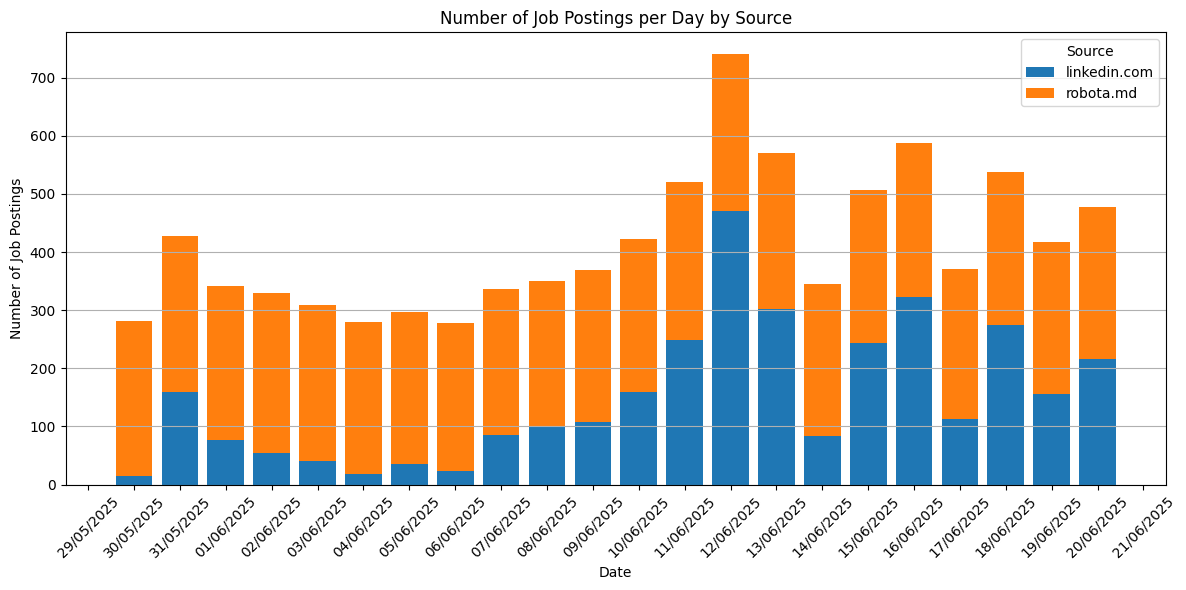

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict
from utils import parse_date
import pandas as pd

# Prepare nested dictionary: {date: {source: count}}
date_source_counts = defaultdict(lambda: defaultdict(int))

for idx, row in df.dropna(subset=['occurrences', 'source']).iterrows():
    source = row['source']
    occ_list = row['occurrences']
    
    if not isinstance(occ_list, list):
        occ_list = [occ_list]
    
    for d in occ_list:
        date_obj = parse_date(d)
        date_source_counts[date_obj][source] += 1

# Get sorted unique dates
all_dates = sorted(date_source_counts.keys())

# Get list of all sources
all_sources = sorted({source for counts in date_source_counts.values() for source in counts})

# Prepare data for stacked bar chart
counts_per_source = {source: [] for source in all_sources}

for date in all_dates:
    counts_for_date = date_source_counts[date]
    for source in all_sources:
        counts_per_source[source].append(counts_for_date.get(source, 0))

# Plot stacked bars
plt.figure(figsize=(12, 6))
bottom = [0] * len(all_dates)

for source in all_sources:
    plt.bar(all_dates, counts_per_source[source], bottom=bottom, label=source)
    bottom = [sum(x) for x in zip(bottom, counts_per_source[source])]

plt.title("Number of Job Postings per Day by Source")
plt.xlabel("Date")
plt.ylabel("Number of Job Postings")
plt.grid(axis='y')

# Format x-axis dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))

plt.xticks(rotation=45)
plt.legend(title="Source")
plt.tight_layout()
plt.show()


## Jobs alive

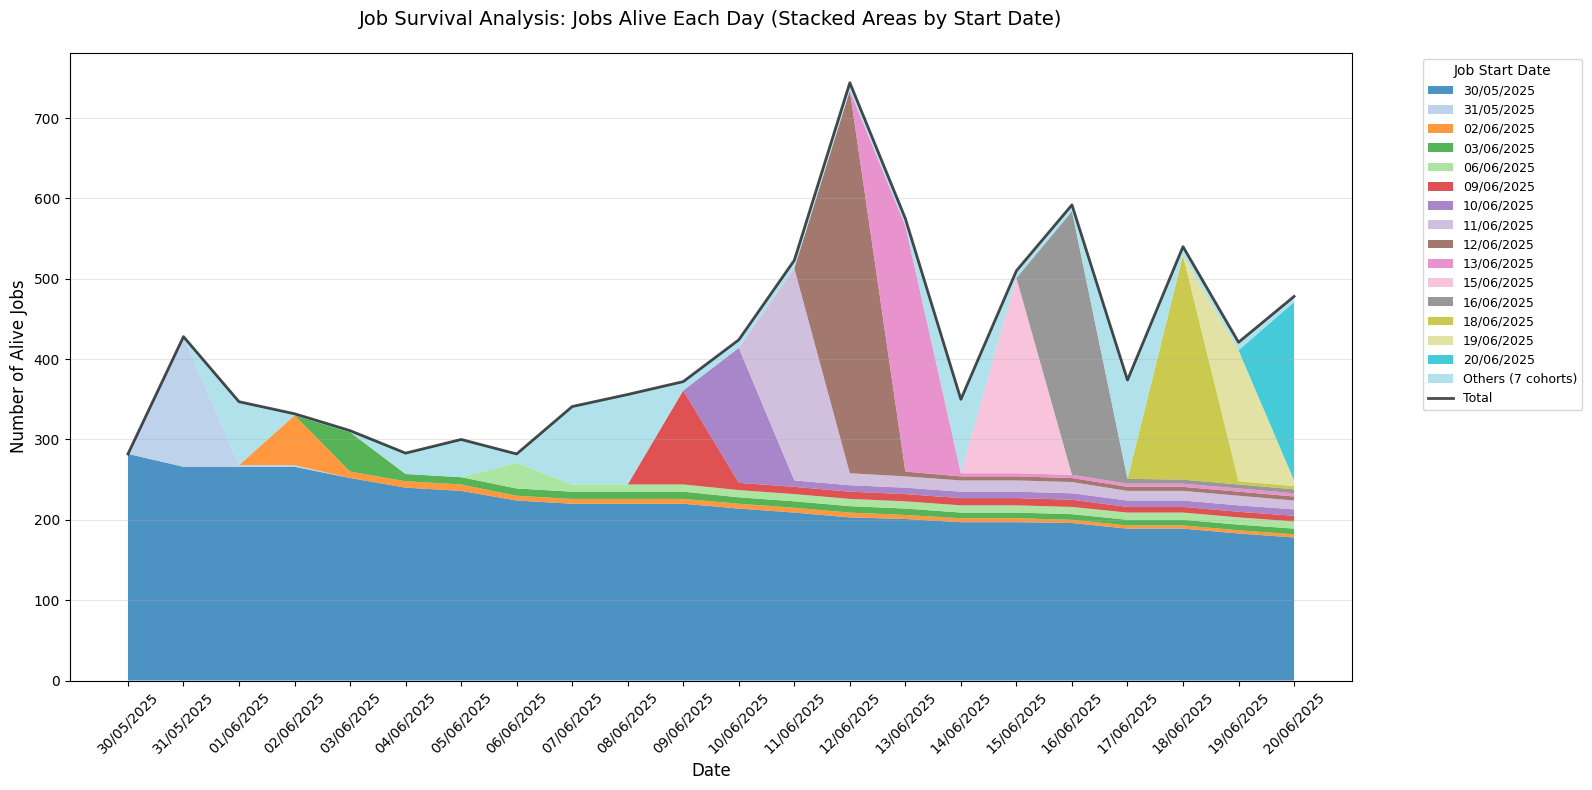

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from collections import defaultdict
from utils import parse_date

# Get all unique dates for x-axis (from both date column and occurrences)
all_dates = set()

# Add dates from date column
for d in df['date'].dropna():
    all_dates.add(parse_date(d))

# Add dates from occurrences
for idx, row in df.iterrows():
    occ_value = row['occurrences']
    try:
        # Skip if None or empty
        if occ_value is None:
            continue
        
        # Handle different data types
        if isinstance(occ_value, (list, np.ndarray)):
            occ_list = occ_value
        else:
            # Single value or string
            occ_list = [occ_value]
        
        for occ_date in occ_list:
            try:
                if occ_date is not None and str(occ_date).strip() != '' and str(occ_date).lower() != 'nan':
                    all_dates.add(parse_date(occ_date))
            except:
                continue  # Skip invalid dates
    except:
        continue  # Skip problematic rows

# Sort all dates for x-axis
x_axis_dates = sorted(all_dates)

# For each x-axis date, count how many jobs from each start date are still alive
survival_data = {}  # {start_date: [count_day1, count_day2, ...]}

# Process each job
for idx, row in df.dropna(subset=['occurrences']).iterrows():
    occ_list = row['occurrences']
    if not isinstance(occ_list, list):
        occ_list = [occ_list]
    
    # Parse all occurrence dates
    parsed_occurrences = []
    for occ_date in occ_list:
        try:
            if occ_date is not None and str(occ_date).strip() != '' and str(occ_date).lower() != 'nan':
                parsed_occurrences.append(parse_date(occ_date))
        except:
            continue
    
    if not parsed_occurrences:
        continue
        
    # Find start and end dates from occurrences
    start_date = min(parsed_occurrences)
    end_date = max(parsed_occurrences)
    
    # Initialize survival data for this start date if needed
    if start_date not in survival_data:
        survival_data[start_date] = [0] * len(x_axis_dates)
    
    # Mark job as alive from start to end date (continuous survival)
    for day_idx, current_day in enumerate(x_axis_dates):
        if start_date <= current_day <= end_date:
            survival_data[start_date][day_idx] += 1

# Sort start dates (oldest first for bottom stacking)
start_dates_sorted = sorted(survival_data.keys())

# Limit the number of visible cohorts for better visualization
MAX_COHORTS = 15  # Show only top cohorts by volume
if len(start_dates_sorted) > MAX_COHORTS:
    # Calculate total jobs for each start date and keep top ones
    cohort_totals = {}
    for start_date in start_dates_sorted:
        cohort_totals[start_date] = sum(survival_data[start_date])
    
    # Sort by total volume and keep top cohorts
    top_cohorts = sorted(cohort_totals.items(), key=lambda x: x[1], reverse=True)[:MAX_COHORTS]
    visible_start_dates = [item[0] for item in top_cohorts]
    visible_start_dates.sort()  # Sort chronologically for stacking
    
    # Aggregate remaining cohorts into "Others"
    others_data = [0] * len(x_axis_dates)
    for start_date in start_dates_sorted:
        if start_date not in visible_start_dates:
            for day_idx in range(len(x_axis_dates)):
                others_data[day_idx] += survival_data[start_date][day_idx]
else:
    visible_start_dates = start_dates_sorted
    others_data = None

# Create the stacked area chart
plt.figure(figsize=(16, 8))

# Use a more distinct color palette
colors = plt.cm.tab20(np.linspace(0, 1, len(visible_start_dates) + (1 if others_data else 0)))

x = np.arange(len(x_axis_dates))

# Prepare data for stackplot
stack_data = []
labels = []

for start_date in visible_start_dates:
    stack_data.append(survival_data[start_date])
    labels.append(start_date.strftime('%d/%m/%Y'))

if others_data and max(others_data) > 0:
    stack_data.append(others_data)
    labels.append(f'Others ({len(start_dates_sorted) - len(visible_start_dates)} cohorts)')

# Create stacked area plot
plt.stackplot(x, *stack_data, labels=labels, colors=colors, alpha=0.8)

# Add a line for total jobs
total_per_day = [sum(survival_data[start_date][day_idx] for start_date in start_dates_sorted) 
                 for day_idx in range(len(x_axis_dates))]
plt.plot(x, total_per_day, color='black', linewidth=2, alpha=0.7, label='Total')

plt.title("Job Survival Analysis: Jobs Alive Each Day (Stacked Areas by Start Date)", fontsize=14, pad=20)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Alive Jobs", fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Format x-axis
ax = plt.gca()
step = max(1, len(x)//15)  # Show ~15 labels
ax.set_xticks(x[::step])
ax.set_xticklabels([d.strftime('%d/%m/%Y') for d in x_axis_dates[::step]], rotation=45)

# Legend
plt.legend(title="Job Start Date", bbox_to_anchor=(1.05, 1), loc='upper left',
          fontsize=9, title_fontsize=10)

plt.tight_layout()
plt.show()

# Most common keywords in job titles

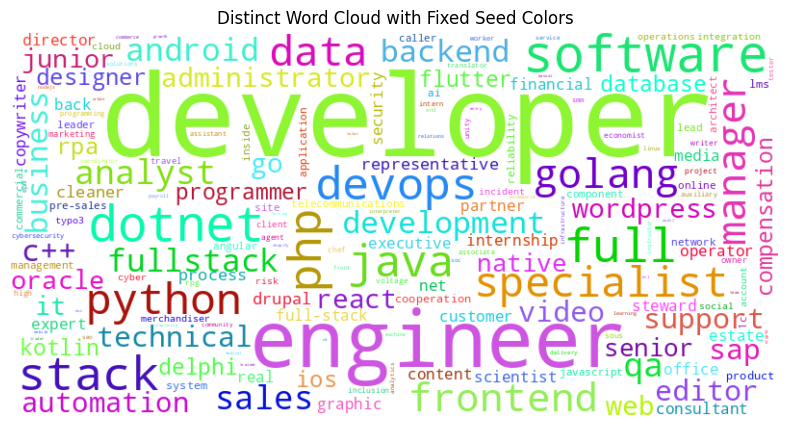

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import random

# 1. Get word frequencies
all_words = [word for title in df['title'].dropna() for word in title.split()]
word_counts = Counter(all_words)
words = list(word_counts.keys())

# 2. Generate n distinct HSL colors using evenly spaced hues
def generate_distinct_colors(n, seed=42):
    random.seed(seed)
    hues = list(range(0, 360, 360 // n))
    random.shuffle(hues)
    return [
        f"hsl({h}, {random.randint(70, 100)}%, {random.randint(35, 65)}%)"
        for h in hues
    ]

# 3. Build color map: word → color
colors = generate_distinct_colors(len(words), seed=9534632359)
word_color_map = dict(zip(words, colors))

# 4. Custom color function using precomputed map
def fixed_color_func(word, *args, **kwargs):
    return word_color_map.get(word, "black")

# 5. Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    collocations=False,
    color_func=fixed_color_func
).generate_from_frequencies(word_counts)

# 6. Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Distinct Word Cloud with Fixed Seed Colors')
plt.show()

## Most common keywords in processed data of rabota.md and linkedin.com

Analyzing columns: ['title', 'min_salary', 'max_salary', 'minimum_education', 'languages', 'experience', 'responsibilities', 'hard_skills', 'soft_skills', 'certifications', 'benefits', 'company_name', 'company_size', 'employment_type', 'work_schedule', 'contract_type', 'remote_work', 'job_categories', 'original_url']
Total records: 3681
Extracting words from processed data...
Processing column: title
Processing column: min_salary
Processing column: max_salary
Processing column: minimum_education
Processing column: languages
Processing column: experience
Processing column: responsibilities
Processing column: hard_skills
Processing column: soft_skills
Processing column: certifications
Processing column: benefits
Processing column: company_name
Processing column: company_size
Processing column: employment_type
Processing column: work_schedule
Processing column: contract_type
Processing column: remote_work
Processing column: job_categories
Processing column: original_url
Total words extrac

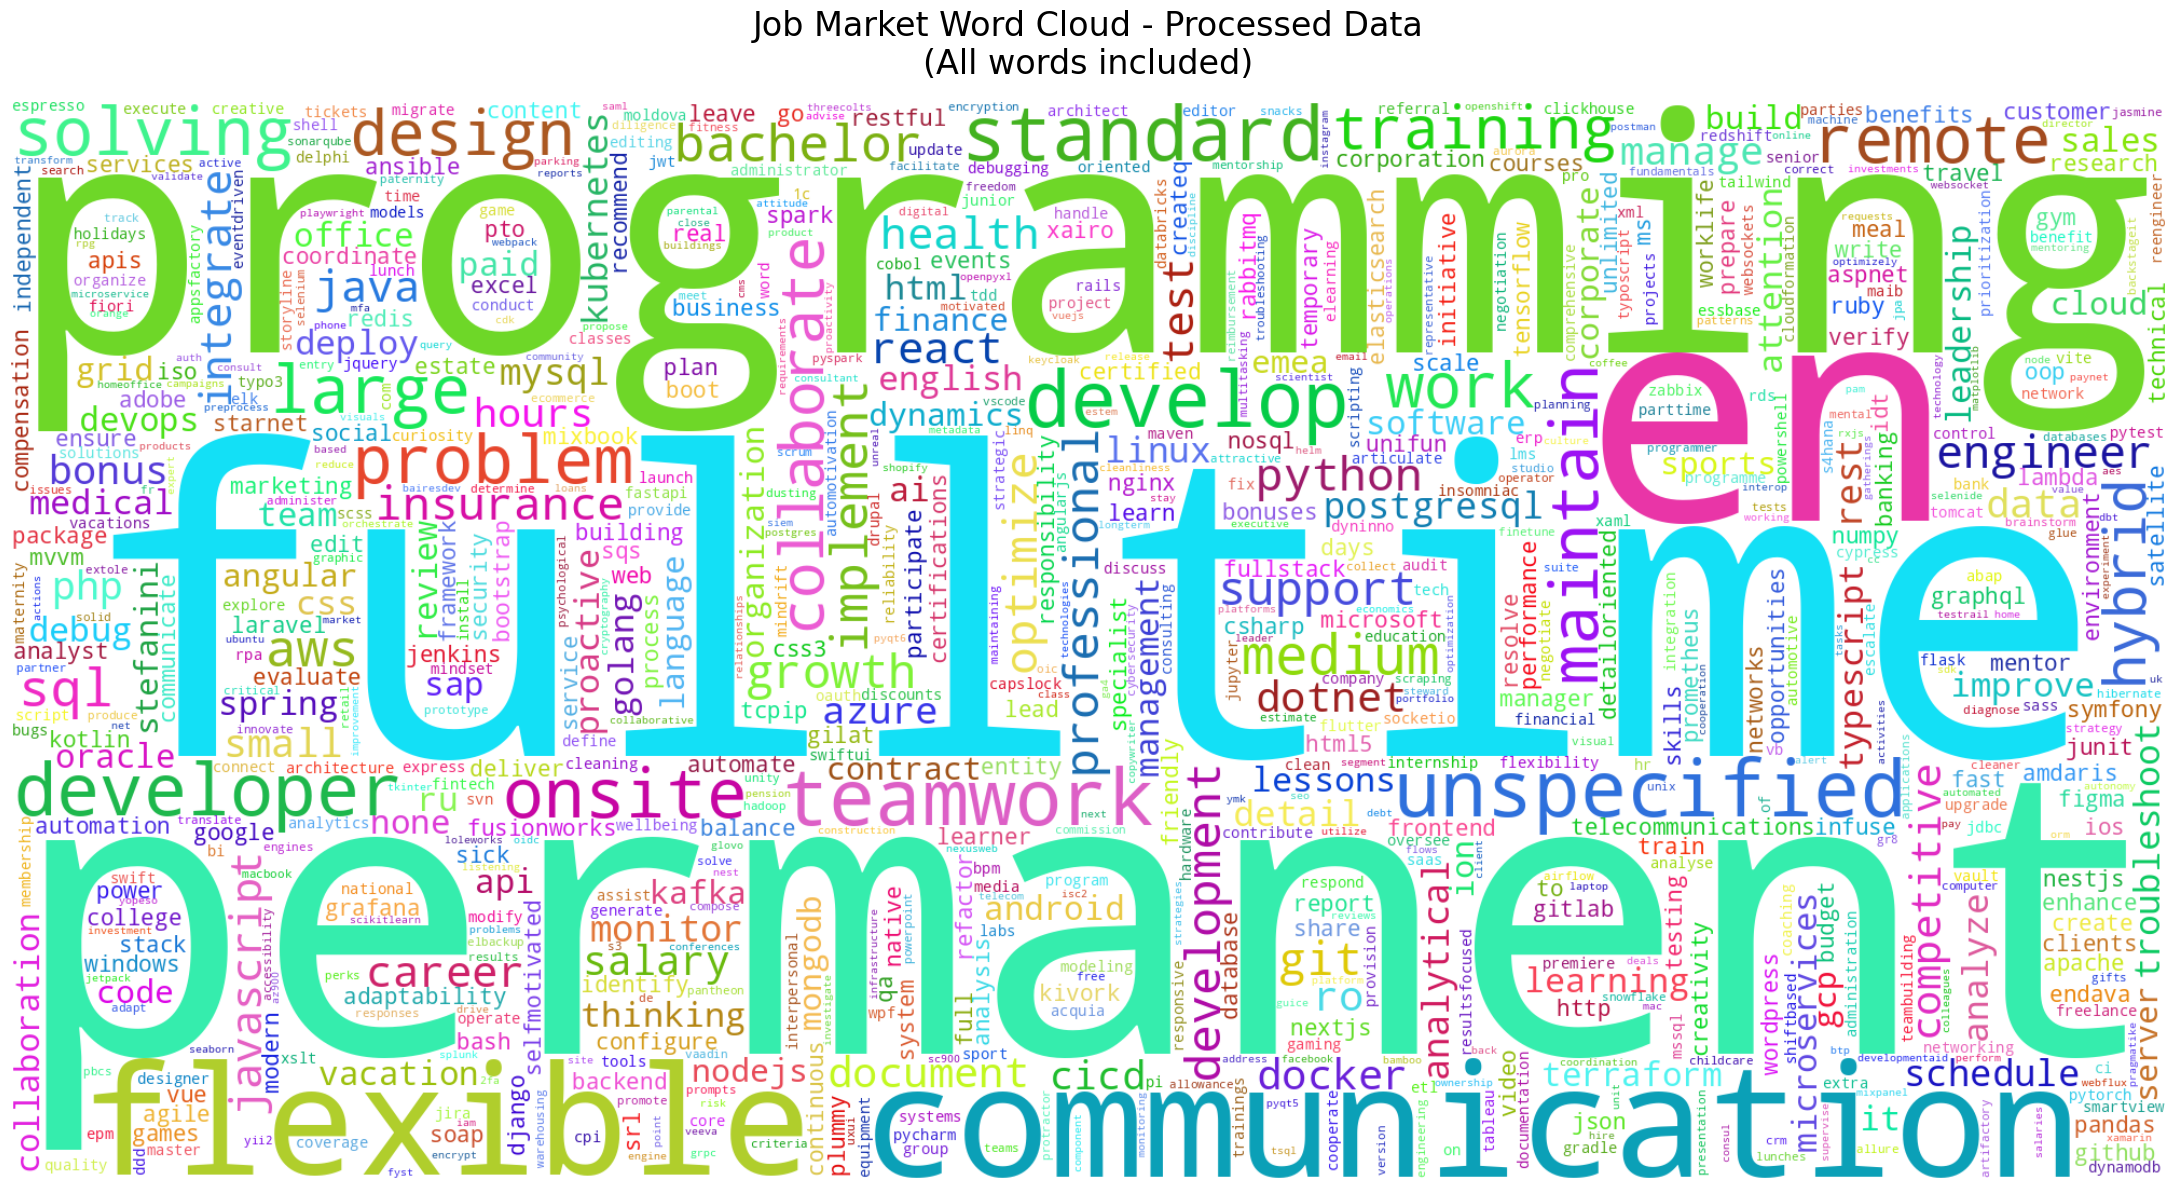


Word Cloud Statistics:
- Total records analyzed: 3681
- Columns analyzed: 19
- Words displayed: 5938
- Most common words: [('fulltime', 3509), ('permanent', 3209), ('programming', 2856), ('en', 2575), ('communication', 2503), ('flexible', 2360), ('unspecified', 2273), ('develop', 2273), ('teamwork', 2253), ('standard', 2106), ('developer', 1930), ('onsite', 1712), ('large', 1636), ('maintain', 1634), ('problem', 1630)]


In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import random
import pandas as pd
import re

# Use the already loaded processed dataframe (df)
# Exclude 'date' and 'occurrences' columns from analysis
columns_to_exclude = ['date', 'occurrences', 'source', 'salary_min', 'salary_max', 'salary_currency', 'city', 'country', 'company_industry']
columns_to_analyze = [col for col in df.columns if col not in columns_to_exclude]

print(f"Analyzing columns: {columns_to_analyze}")
print(f"Total records: {len(df)}")

def clean_word(word):
    """Basic word cleaning - only remove punctuation"""
    # Remove punctuation and normalize
    word = re.sub(r'[^\w]', '', word).lower().strip()
    
    # Skip if too short or numeric
    if len(word) < 2 or word.isdigit():
        return None
    
    return word

def extract_words_from_processed_df(df, columns_to_analyze):
    """Extract words from all specified columns"""
    all_words = []
    
    for col in columns_to_analyze:
        if col in df.columns:
            print(f"Processing column: {col}")
            for val in df[col].dropna():
                if isinstance(val, list):
                    for item in val:
                        words = str(item).split()
                        for word in words:
                            cleaned = clean_word(word)
                            if cleaned:
                                all_words.append(cleaned)
                else:
                    words = str(val).split()
                    for word in words:
                        cleaned = clean_word(word)
                        if cleaned:
                            all_words.append(cleaned)
    
    return all_words

# Extract words from processed dataframe
print("Extracting words from processed data...")
all_words = extract_words_from_processed_df(df, columns_to_analyze)
print(f"Total words extracted: {len(all_words)}")

# Count word frequencies
word_counts = Counter(all_words)
print(f"Unique words: {len(word_counts)}")
print(f"Top 10 words: {word_counts.most_common(10)}")

words = list(word_counts.keys())

# Generate distinct HSL colors with better distribution
def generate_distinct_colors(n, seed=42):
    """Generate visually distinct colors using golden angle"""
    random.seed(seed)
    if n == 0:
        return []
    
    colors = []
    golden_angle = 137.508  # Golden angle in degrees
    
    for i in range(n):
        hue = (i * golden_angle) % 360
        saturation = random.randint(65, 95)  # High saturation
        lightness = random.randint(35, 65)   # Medium lightness
        colors.append(f"hsl({hue:.0f}, {saturation}%, {lightness}%)")
    
    return colors

# Create word-color map
colors = generate_distinct_colors(len(words), seed=9534632359)
word_color_map = dict(zip(words, colors))

def fixed_color_func(word, *args, **kwargs):
    return word_color_map.get(word, "black")

# Generate word cloud
wordcloud = WordCloud(
    max_words=1000,
    width=2000,
    height=1000,
    background_color='white',
    collocations=False,
    color_func=fixed_color_func,
    relative_scaling=0.5,
    min_font_size=8
).generate_from_frequencies(word_counts)

# Plot
plt.figure(figsize=(24, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Job Market Word Cloud - Processed Data\n(All words included)', 
          fontsize=24, pad=20)
plt.tight_layout()
plt.show()

# Print statistics
print(f"\nWord Cloud Statistics:")
print(f"- Total records analyzed: {len(df)}")
print(f"- Columns analyzed: {len(columns_to_analyze)}")
print(f"- Words displayed: {len(word_counts)}")
print(f"- Most common words: {word_counts.most_common(15)}")

## Most common keywords in raw data of rabota.md and linkedin.com

Extracting words from Robota...
Processing robota column: vacancy-title
Processing robota column: company-title
Processing robota column: sidebar
Processing robota column: vacancy-content
Robota words extracted: 43133
Extracting words from LinkedIn...
Processing linkedin column: job_title
Processing linkedin column: company_name
Processing linkedin column: job_description
Processing linkedin column: seniority_level
Processing linkedin column: employment_type
Processing linkedin column: industries
Processing linkedin column: skills
LinkedIn words extracted: 706698
Total unique words (min freq 2): 10374
Top 10 words: [('design', 5306), ('busi', 3620), ('services', 3383), ('develop', 3221), ('learn', 3132), ('solutions', 3035), ('understand', 2977), ('technical', 2928), ('build', 2859), ('systems', 2746)]


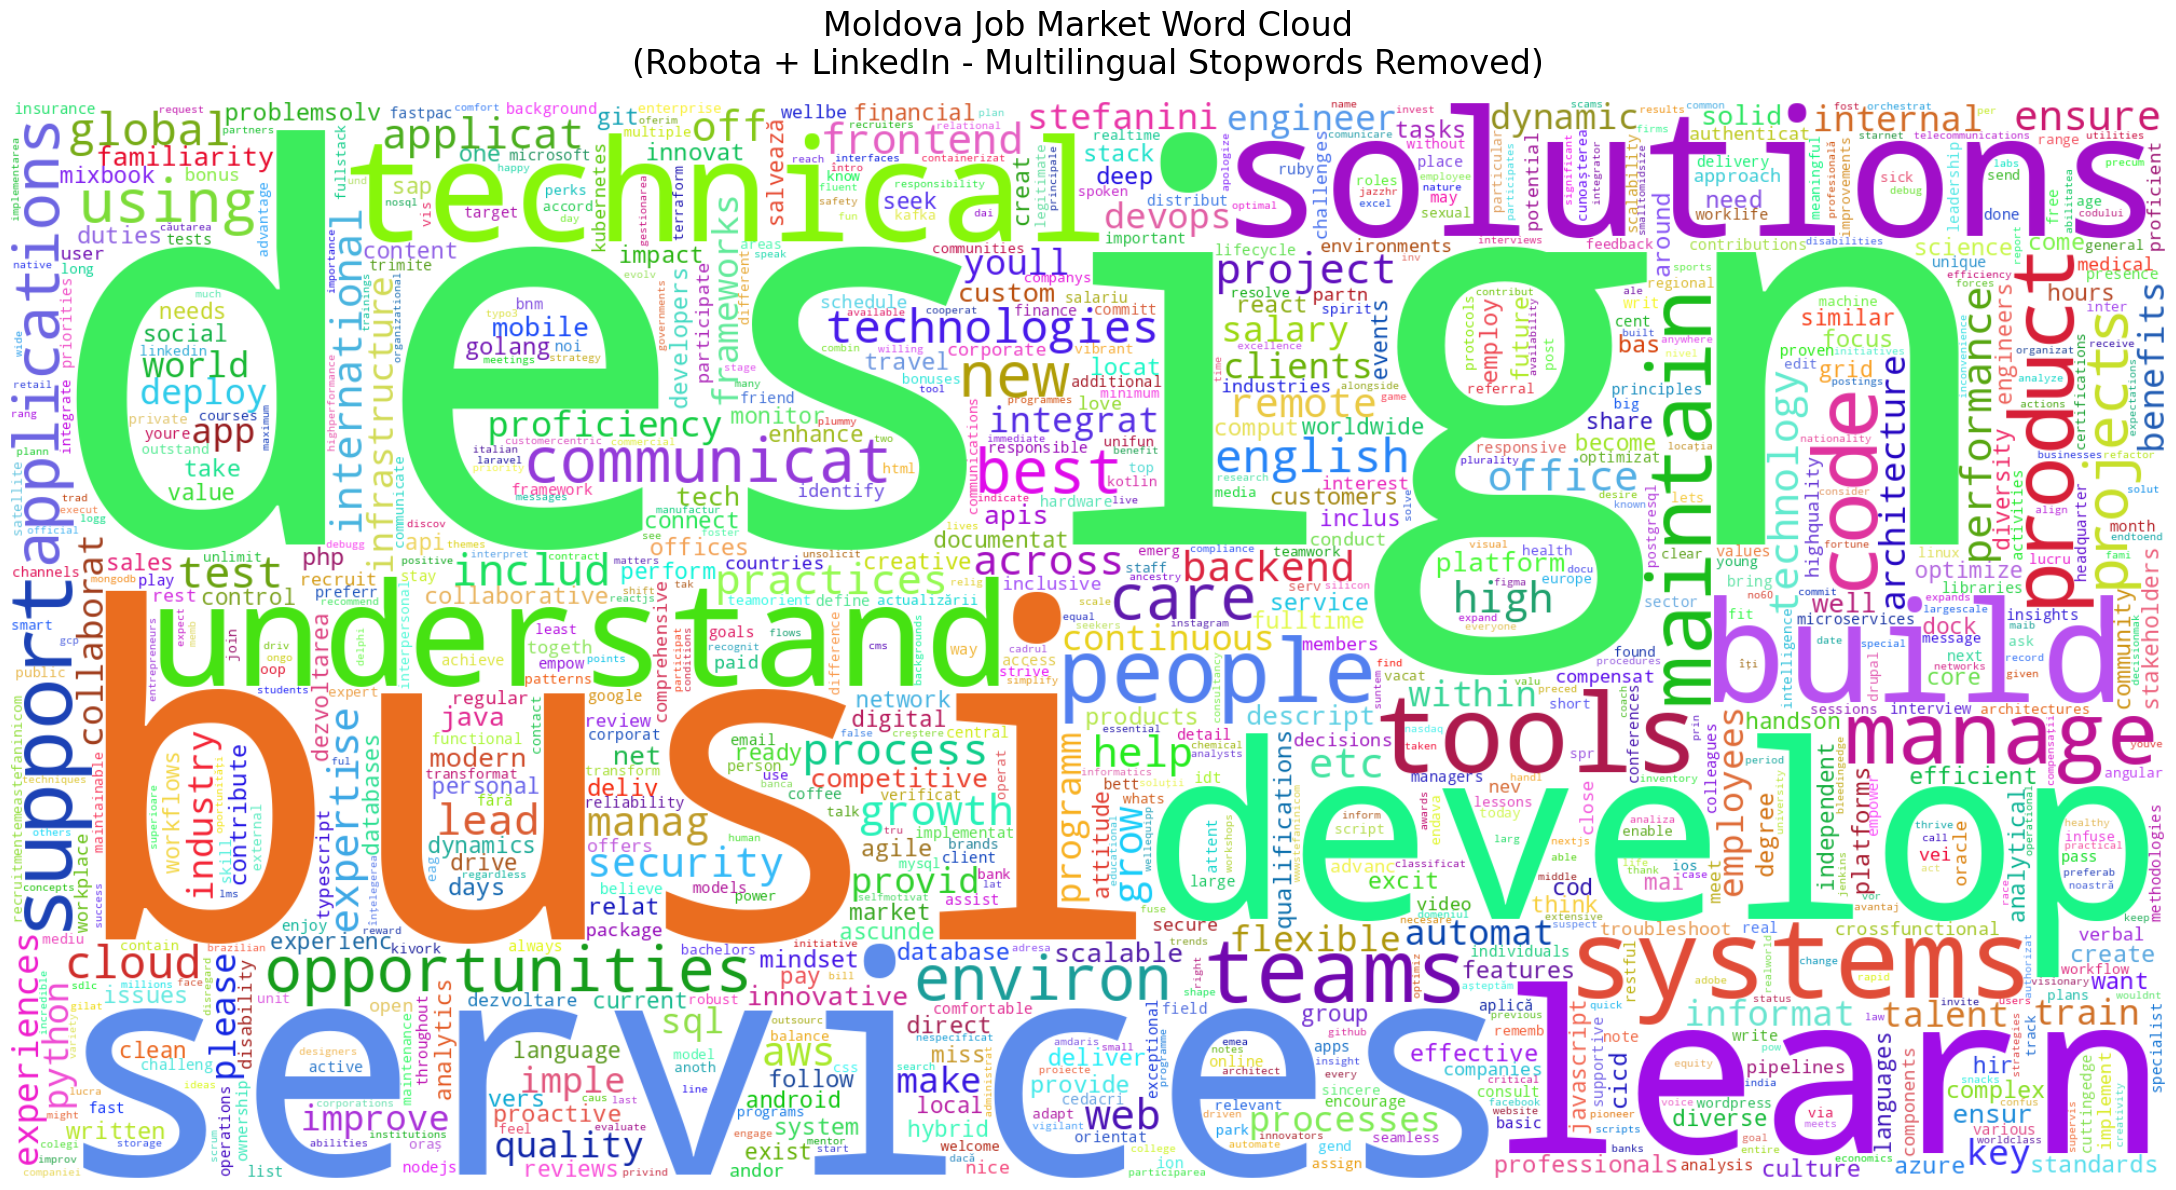


Word Cloud Statistics:
- Total jobs analyzed: 376 (Robota) + 3271 (LinkedIn)
- Words displayed: 10374
- Most common technical terms: ['design', 'services', 'develop', 'learn', 'solutions', 'understand', 'technical', 'build', 'systems', 'tools']


In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import random
import pandas as pd
import re

# Load data from raw tables
robota_df = pd.DataFrame(db.table(TABLE_ROBOTA_MD_RAW).all())
linkedin_df = pd.DataFrame(db.table(TABLE_LINKEDIN_RAW).all())

# Define source-specific fields
robota_columns = ['vacancy-title', 'company-title', 'sidebar', 'vacancy-content']
linkedin_columns = ['job_title', 'company_name', 'job_description', 'seniority_level', 'employment_type', 'industries', 'skills']

# Comprehensive stopwords (English + Romanian + Russian + Job-specific)
stopwords = set(STOPWORDS)

# Romanian stopwords
romanian_stopwords = {
    'și', 'în', 'de', 'la', 'cu', 'pe', 'pentru', 'din', 'către', 'sau', 'dar', 'că', 'cel', 'cea', 'cei', 'cele',
    'un', 'una', 'unei', 'unui', 'acestui', 'acestei', 'această', 'acest', 'aceste', 'aceștia', 'acestea',
    'muncă', 'munca', 'locul', 'locului', 'angajatorului', 'angajator', 'nu', 'contează', 'data', 'datei',
    'experiența', 'experiență', 'ani', 'anul', 'program', 'programul', 'full', 'time', 'part', 'studii',
    'căutare', 'căutări', 'locuri', 'joburi', 'job', 'poziție', 'poziția', 'candidat', 'candidatul', 'candidați',
    'responsabilități', 'responsabilitate', 'cerințe', 'cerință', 'competențe', 'competența', 'abilități', 'abilitate',
    'cunoștințe', 'cunoaștere', 'echipa', 'echipă', 'companie', 'compania', 'firma', 'firmă', 'aplicant', 'aplicanți'
}

# Russian stopwords
russian_stopwords = {
    'и', 'в', 'на', 'с', 'по', 'для', 'от', 'за', 'к', 'до', 'из', 'у', 'о', 'об', 'не', 'что', 'как', 'это',
    'все', 'или', 'так', 'его', 'её', 'их', 'мы', 'вы', 'он', 'она', 'они', 'наш', 'ваш', 'их', 'этот', 'эта', 'эти',
    'работа', 'работы', 'работе', 'работу', 'место', 'места', 'опыт', 'опыта', 'год', 'года', 'лет', 'компания', 'компании',
    'кандидат', 'кандидата', 'требования', 'требование', 'обязанности', 'обязанность', 'навыки', 'навык', 'знание', 'знания',
    'умение', 'умения', 'специалист', 'специалиста', 'должность', 'позиция', 'вакансия', 'команда', 'команды'
}

# Job-specific English stopwords
job_stopwords = {
    'experience', 'work', 'working', 'years', 'year', 'requirements', 'required', 'must', 'should', 'will', 'would',
    'job', 'position', 'role', 'candidate', 'candidates', 'team', 'company', 'responsibilities', 'skills', 'skill',
    'knowledge', 'ability', 'strong', 'good', 'excellent', 'can', 'could', 'level', 'senior', 'junior', 'mid',
    'developer', 'engineer', 'software', 'development', 'plus', 'looking', 'seek', 'ideal', 'perfect', 'great',
    'opportunity', 'join', 'passionate', 'motivated', 'dedicated', 'professional', 'successful', 'collaborate'
}

# Location-specific stopwords
location_stopwords = {
    'chișinău', 'chisinau', 'moldova', 'moldovan', 'moldovei', 'republic', 'md', 'romania', 'bucuresti', 'bucharest'
}

# Combine all stopwords
stopwords |= romanian_stopwords | russian_stopwords | job_stopwords | location_stopwords

def clean_word(word):
    """Clean and normalize a single word"""
    # Remove punctuation and normalize
    word = re.sub(r'[^\w]', '', word).lower().strip()
    
    # Skip if too short, numeric, or stopword
    if len(word) < 3 or word.isdigit() or word in stopwords:
        return None
    
    # Remove common suffixes for better grouping
    suffixes = ['ing', 'ed', 'er', 'est', 'ly', 'ion', 'tion', 'sion', 'ness', 'ment']
    for suffix in suffixes:
        if word.endswith(suffix) and len(word) > len(suffix) + 2:
            word = word[:-len(suffix)]
            break
    
    return word

def extract_words_from_fields(df, source):
    """Extract and clean words from relevant fields"""
    all_words = []
    
    if source == 'robota':
        fields = robota_columns
    elif source == 'linkedin':
        fields = linkedin_columns
    else:
        return all_words
    
    for col in fields:
        if col in df.columns:
            print(f"Processing {source} column: {col}")
            for val in df[col].dropna():
                if isinstance(val, list):
                    for item in val:
                        words = str(item).split()
                        for word in words:
                            cleaned = clean_word(word)
                            if cleaned:
                                all_words.append(cleaned)
                else:
                    words = str(val).split()
                    for word in words:
                        cleaned = clean_word(word)
                        if cleaned:
                            all_words.append(cleaned)
    
    return all_words

# Extract words from both sources
print("Extracting words from Robota...")
robota_words = extract_words_from_fields(robota_df, 'robota')
print(f"Robota words extracted: {len(robota_words)}")

print("Extracting words from LinkedIn...")
linkedin_words = extract_words_from_fields(linkedin_df, 'linkedin')
print(f"LinkedIn words extracted: {len(linkedin_words)}")

# Combine and count
all_words = robota_words + linkedin_words
word_counts = Counter(all_words)

# Filter out very rare words (appear only once) to reduce noise
min_frequency = 2
word_counts = {word: count for word, count in word_counts.items() if count >= min_frequency}

print(f"Total unique words (min freq {min_frequency}): {len(word_counts)}")
print(f"Top 10 words: {Counter(word_counts).most_common(10)}")

words = list(word_counts.keys())

# Generate distinct HSL colors with better distribution
def generate_distinct_colors(n, seed=42):
    """Generate visually distinct colors using golden angle"""
    random.seed(seed)
    if n == 0:
        return []
    
    colors = []
    golden_angle = 137.508  # Golden angle in degrees
    
    for i in range(n):
        hue = (i * golden_angle) % 360
        saturation = random.randint(65, 95)  # High saturation
        lightness = random.randint(35, 65)   # Medium lightness
        colors.append(f"hsl({hue:.0f}, {saturation}%, {lightness}%)")
    
    return colors

# Create word-color map
colors = generate_distinct_colors(len(words), seed=9534632359)
word_color_map = dict(zip(words, colors))

def fixed_color_func(word, *args, **kwargs):
    return word_color_map.get(word, "black")

# Generate word cloud
wordcloud = WordCloud(
    max_words=1000,  # Reduced for better readability
    width=2000,     # Slightly larger
    height=1000,
    background_color='white',
    collocations=False,
    color_func=fixed_color_func,
    relative_scaling=0.5,
    min_font_size=8
).generate_from_frequencies(word_counts)

# Plot with better formatting
plt.figure(figsize=(24, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Moldova Job Market Word Cloud\n(Robota + LinkedIn - Multilingual Stopwords Removed)', 
          fontsize=24, pad=20)
plt.tight_layout()
plt.show()

# Optional: Print statistics
print(f"\nWord Cloud Statistics:")
print(f"- Total jobs analyzed: {len(robota_df)} (Robota) + {len(linkedin_df)} (LinkedIn)")
print(f"- Words displayed: {len(word_counts)}")
print(f"- Most common technical terms: {[word for word, count in Counter(word_counts).most_common(20) if len(word) > 4][:10]}")

In [15]:
# Raw, non processed titles
# Get the value counts of the 'title' column
title_counts = df['title'].value_counts()

# Set pandas display options to show all rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)

# Display all job title occurrences
print("All Job Title Occurrences:")
print(title_counts)

All Job Title Occurrences:
title
php developer                          168
java developer                         160
dotnet developer                       158
devops engineer                        152
python developer                       136
full stack developer                   123
golang developer                       108
android developer                       81
software engineer                       79
fullstack developer                     76
c++ developer                           75
data engineer                           69
frontend developer                      61
backend developer                       57
frontend engineer                       54
full stack engineer                     54
qa automation engineer                  53
web developer                           53
go developer                            53
wordpress developer                     49
junior developer                        48
video editor                            46
react native develope

# Chrrypick job positionswith regex

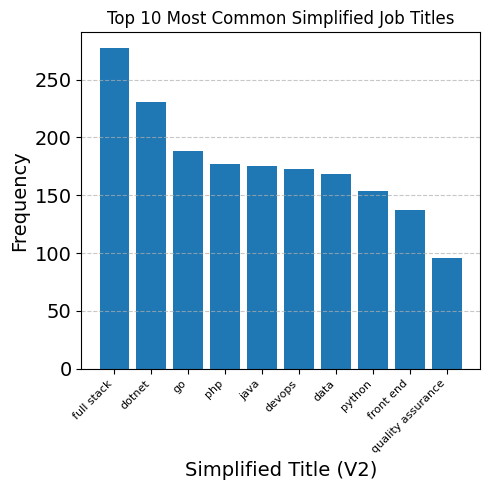


All Simplified Job Title Occurrences (Programming Languages Top, iOS/Android Higher, Full Stack Lower):
simplified_title_reordered_v2
full stack              277
dotnet                  231
go                      188
php                     177
java                    175
devops                  173
data                    168
python                  154
front end               137
quality assurance        96
android                  81
c/cpp                    75
back end                 71
javascript               68
sql                      51
wordpress                50
ios                      37
graphic designer         36
kotlin                   32
flutter                  30
security analyst         16
administrator            15
site reliability         12
system                   11
architect                10
business analyst          8
project manager           7
product manager           6
system administrator      2
unreal                    2
embedded                 

In [16]:
# Cherry Pick with regex best words

# 1. Define dictionary with keyword / simplified titles you experienceect (priority matters implicitly by order)
JOB_KEYWORD_MAPPING_REORDERED_V2 = {
    # Programming Languages (Prioritized and ordered by perceived commonality/specificity)
    'python': r'python',
    'kotlin': r'kotlin',
    'java': r'java|full stack java|spring',
    'dotnet': r'\.net|dot[-\s]?net|net|asp\.net|aspdotdotnet|dotnetwork|dotdotnet|csharp/dotdotnet|aspdotdotnet dotdotnet|dotdotnet core|dotdotnet developers|c#|c[-\s]?sharp|csharp|asp\.net|dotdotnet',
    'javascript': r'node\.?js|nodejavascript|reactjs|react|react native|angularjs|angular|vue.javascript|vue.js', # Combining related JS frameworks
    'php': r'php symfony|php',
    'go': r'golang|go',
    'rust': r'rust',
    'swift': r'swift',
    'haskel': r'haskel|lisp',
    'ruby': r'ruby|rails', # Assuming Rails is specific to Ruby
    'c/cpp': r'c\+\+|c/cpp',
    'sql': r'sql|oracle|microsoft dynamics', # Databases related to programming

    # Mobile Development
    'ios': r'ios',
    'android': r'android',
    'flutter': r'flutter/dart|flutter',

    # Front-End and Back-End (Full Stack below)
    'front end': r'front[-\s]?end',
    'back end': r'back[-\s]?end|dotdotnet back end|back end nodejavascript',
    'full stack': r'full[-\s]?stack|full stack web|full stack web development|full stack development|arhitect full stack|dezvoltator full stack|full stack php|full stack dotdotnet',

    # Quality Assurance
    'quality assurance': r'qa|quality assurance|quality assurance analyst|automation quality assurance|quality assurance tester|tester',

    # Data Related
    'data': r'data analyst|data|data analyst data scientist|etl data tester|data steward',

    # DevOps and System Administration
    'devops': r'devops|azure devops|system devops',
    'system administrator': r'system administrator|linux dotnetwork administrator|system administrator helpdesk|web administrator',
    'linux administrator': r'linux',
    'monitoring operator': r'monitoring operator',
    'infrastructure support': r'infrastructure support',
    'system': r'system|linux dotnetwork system administrator',

    # Management/Leadership
    'project manager': r'project manager|software project manager',
    'product manager': r'product manager',
    'technology officer': r'technology officer',
    'delivery manager': r'delivery manager',
    'team lead': r'team lead', # Assuming this was a desired category (not in original, but often relevant)
    'architect': r'architect',

    # Analysis and Design
    'business analyst': r'business analyst|business analyst project coordinator',
    'ui ux designer': r'ui[/]?ux',
    'erp analyst': r'erp analyst',
    'market research analyst': r'market research analyst',
    'graphic designer': r'grafic designer|graphic designer|designer',
    'artist': r'artist',

    # Other Technical Roles
    'embedded': r'embedded|mcu',
    'unreal': r'unreal engine|unreal game |unrealdeveloper',
    'security analyst': r'security analyst',
    'cybersecurity': r'cybersecurity',
    'site reliability': r'site reliability',
    'mobile application': r'mobile application', # Keeping it here as it's a type of application
    'web': r'веб|веб-программист|web designer', # Broader web category
    'r&d': r'r&d',
    'wordpress': r'wordpress', # Could be web development, but often distinct
    'administrator': r'administrator', # Very general
        
    'UNKNOWN': 'other', # Default category if no keyword is found
}

def categorize_title_reordered_v2(title):
    """
    Passes through the job title and categorizes it based on the reordered
    predefined keywords with programming languages on top, full stack below
    front/back end, and iOS/Android higher.
    """
    if isinstance(title, str):
        processed_title = title.lower().strip()
        processed_title = re.sub(r'\([^)]*\)', '', processed_title).strip() # Remove parentheses content

        for category, pattern in JOB_KEYWORD_MAPPING_REORDERED_V2.items():
            if re.search(pattern, processed_title):
                return category
        return 'other'
    return 'other'

# Recalculate categorization
df['simplified_title_reordered_v2'] = df['title'].apply(categorize_title_reordered_v2)


# Get the value counts of the prioritized simplified titles (version 2)
simplified_title_counts_reordered_v2 = df['simplified_title_reordered_v2'].value_counts()

# remove other keyword
del simplified_title_counts_reordered_v2["other"]

top10_titles = simplified_title_counts_reordered_v2.head(10)

plt.figure(figsize=(5, 5))
plt.bar(top10_titles.index, top10_titles.values)
plt.title('Top 10 Most Common Simplified Job Titles')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Simplified Title (V2)', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# Display all prioritized simplified job title occurrences (version 2)
print("\nAll Simplified Job Title Occurrences (Programming Languages Top, iOS/Android Higher, Full Stack Lower):")
print(simplified_title_counts_reordered_v2)


In [17]:
import pandas as pd
from collections import defaultdict, Counter

def get_ngrams(text, n):
    """
    Generates a set of n-grams from the given text.

    Args:
        text (str): The input text.
        n (int): The length of the n-grams.

    Returns:
        set: A set of n-grams.  Returns an empty set if text is shorter than n.
    """
    if len(text) < n:
        return set()
    return set(text[i:i+n] for i in range(len(text) - n + 1))

def ngram_similarity(term1, term2, n=3):
    """
    Calculates the n-gram similarity between two terms.

    Args:
        term1 (str): The first term.
        term2 (str): The second term.
        n (int, optional): The length of the n-grams. Defaults to 3.

    Returns:
        float: The n-gram similarity (between 0 and 1). Returns 0 if both terms are empty.
    """
    ngrams1 = get_ngrams(term1, n)
    ngrams2 = get_ngrams(term2, n)
    intersection = ngrams1.intersection(ngrams2)
    union = ngrams1.union(ngrams2)
    return len(intersection) / len(union) if union else 0.0  # Handle empty case

def cluster_terms_by_ngram_similarity(df, column_name, similarity_threshold=0.15, n=3, b_print=False):
    """
    Clusters terms in a DataFrame column based on n-gram similarity, and prints the clusters.

    Args:
        df (pd.DataFrame): The DataFrame containing the terms.
        column_name (str): The name of the column containing the terms (lists of strings).
        similarity_threshold (float, optional): The similarity threshold for clustering. Defaults to 0.15.
        n (int, optional): The length of the n-grams to use for comparison. Defaults to 3.
    """
    # 1. Extract and flatten the list of terms, handling NaNs robustly
    all_things = [tech for tech_list in df[column_name].dropna() for tech in (tech_list if isinstance(tech_list, list) else [tech_list])]

    # 2. Count occurrences of each term
    counts = Counter(all_things)

    # 3. Initialize data structures for clustering
    clusters = defaultdict(list)
    terms = list(counts.keys())
    assigned = set()

    # 4. Perform the clustering
    for i, term1 in enumerate(terms):
        if i not in assigned:
            clusters[term1].append(term1)
            assigned.add(i)
            for j in range(i + 1, len(terms)):
                if j not in assigned:
                    similarity = ngram_similarity(term1, terms[j], n=n)
                    if similarity >= similarity_threshold:
                        clusters[term1].append(terms[j])
                        assigned.add(j)

    if b_print == True:
        # 5. Print the results
        print(f"Potential Clusters (N-gram, Threshold={similarity_threshold}, N={n}):")
        if not clusters:
            print("No clusters found.")  # Handle the case where no clusters are formed.
            return
    
        for key, value in clusters.items():
            if len(value) > 1:
                print(f"  {key}: {', '.join(value)}")
            
    return clusters #returning the clusters, in case the user wants to use them

In [18]:
def analyze_and_visualize_consolidated_terms(df, column_name, similarity_threshold=0.15, n=2, top_n=20, 
                                     figsize=(10, 5), rotation=45, show_details=True):
    """
    Analyzes, consolidates, and visualizes terms from a specified DataFrame column,
    grouping similar terms based on n-gram similarity.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the terms.
        column_name (str): The name of the column containing the terms (lists of strings).
        similarity_threshold (float, optional): The similarity threshold for clustering. Defaults to 0.15.
        n (int, optional): The length of the n-grams to use for comparison. Defaults to 2.
        top_n (int, optional): Number of top terms to visualize. Defaults to 20.
        figsize (tuple, optional): Figure size for the plot. Defaults to (10, 5).
        rotation (int, optional): Rotation angle for x-axis labels. Defaults to 45.
        show_details (bool, optional): Whether to print consolidation details. Defaults to True.
        
    Returns:
        tuple: (consolidated_counts, clusters) - Counter object with consolidated counts and clusters dictionary
    """
    import matplotlib.pyplot as plt
    from collections import Counter
    
    # Extract and flatten all terms from the specified column
    all_terms = [term for term_list in df[column_name].dropna() for term in 
                (term_list if isinstance(term_list, list) else [term_list])]
    
    # Count occurrences
    original_counts = Counter(all_terms)
    
    # Generate clusters
    clusters = cluster_terms_by_ngram_similarity(df, column_name, 
                                               similarity_threshold=similarity_threshold, n=n)
    
    # Create a mapping from each term to its cluster representative (the cluster key)
    term_to_cluster = {}
    for cluster_key, terms in clusters.items():
        for term in terms:
            term_to_cluster[term] = cluster_key
    
    # Consolidate counts based on clusters
    consolidated_counts = Counter()
    for term, count in original_counts.items():
        # If the term is in a cluster, add its count to the cluster key
        if term in term_to_cluster:
            consolidated_counts[term_to_cluster[term]] += count
        else:
            # If not in any cluster, keep it as is
            consolidated_counts[term] += count
    
    # Plot top N most common consolidated terms
    top_terms = dict(consolidated_counts.most_common(top_n))
    plt.figure(figsize=figsize)
    plt.bar(top_terms.keys(), top_terms.values())
    plt.title(f'Top {top_n} Most Common {column_name.capitalize()}')
    plt.xticks(rotation=rotation, ha='right')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    # Print full list sorted by frequency
    print(f"Full list of consolidated {column_name} term frequencies:\n")
    for term, count in consolidated_counts.most_common():
        print(f"{term:20} {count}")
    
    # Optionally, print which terms were consolidated
    if show_details:
        print("\nConsolidation details:")
        for cluster_key, terms in clusters.items():
            if len(terms) > 1:
                total_count = sum(original_counts[term] for term in terms)
                print(f"{cluster_key} ({total_count}): {', '.join(terms)}")
    
    return consolidated_counts, clusters

### analyze_and_visualize_consolidated_terms_v2 v2

In [19]:
def analyze_and_visualize_consolidated_terms_v2(df, column_name, similarity_threshold=0.15, n=2, top_n=20,
                                              figsize=(10, 5), rotation=45, show_details=False, 
                                              date_column="occurrences", show_daily_average=False, silent=True):
    """
    Analyze, consolidate, and visualize terms from a DataFrame column.
    Handles both single values and lists of values.
    Total = unique occurrences across all job postings
    Daily Average = total occurrences / unique days
    """
    import matplotlib.pyplot as plt
    from collections import Counter
    import pandas as pd
    from datetime import datetime

    # Helper: your clustering function
    clusters = cluster_terms_by_ngram_similarity(df, column_name,
                                                similarity_threshold=similarity_threshold, n=n)

    # Count occurrences - handle both single values and lists
    original_counts = Counter()
    term_to_dates = {}  # Track which dates each term appears on
    
    for idx, row in df.iterrows():
        column_value = row[column_name]
        occurrences = row.get('occurrences', [])
        
        # Get unique dates for this row
        row_dates = set()
        if occurrences is not None and isinstance(occurrences, list):
            for date_str in occurrences:
                if isinstance(date_str, str) and date_str.strip():
                    row_dates.add(date_str.strip())
        
        # Handle the column value - could be single value or list
        terms_in_row = []
        
        # Fixed: Check for list first, then handle accordingly
        if isinstance(column_value, list):
            # Column contains lists (like benefits, skills)
            for item in column_value:
                if item is not None and pd.notna(item) and str(item).strip():
                    terms_in_row.append(str(item).strip())
        else:
            # Column contains single values (like company_name) 
            if column_value is not None and pd.notna(column_value) and str(column_value).strip():
                terms_in_row.append(str(column_value).strip())
        
        # Count each term and track its dates
        for term in terms_in_row:
            original_counts[term] += 1
            
            if term not in term_to_dates:
                term_to_dates[term] = set()
            term_to_dates[term].update(row_dates)

    # Map each term to its cluster representative
    term_to_cluster = {}
    for cluster_key, cluster_terms in clusters.items():
        if isinstance(cluster_terms, list):
            representative = cluster_terms[0] if cluster_terms else cluster_key
            for term in cluster_terms:
                term_to_cluster[term] = representative
        else:
            term_to_cluster[cluster_key] = cluster_terms

    # Consolidate counts by cluster representative
    consolidated_counts = Counter()
    consolidated_dates = {}
    
    for term, count in original_counts.items():
        representative = term_to_cluster.get(term, term)
        consolidated_counts[representative] += count
        
        # Consolidate dates for the representative
        if representative not in consolidated_dates:
            consolidated_dates[representative] = set()
        
        # Add all dates where this term appeared
        consolidated_dates[representative].update(term_to_dates.get(term, set()))

    # Calculate daily averages: total occurrences / unique days
    daily_averages = {}
    if show_daily_average:
        for term in consolidated_counts.keys():
            total_occurrences = consolidated_counts[term]
            unique_days = len(consolidated_dates.get(term, set()))
            
            if unique_days > 0:
                daily_averages[term] = total_occurrences / unique_days
            else:
                daily_averages[term] = 0

    # Get top terms
    top_terms = dict(consolidated_counts.most_common(top_n))

    # Create visualization
    plt.figure(figsize=figsize)
    
    terms = list(top_terms.keys())
    totals = [top_terms[t] for t in terms]
    
    if show_daily_average and daily_averages:
        averages = [daily_averages.get(t, 0) for t in terms]
        
        # Create bars: total in light blue, average portion in red/orange
        bars_total = plt.bar(terms, totals, color='lightblue', alpha=0.7, label=f'Total {column_name.replace("_", " ").title()}')
        bars_avg = plt.bar(terms, averages, color='red', alpha=0.8, label='Daily Average')
        
        plt.title(f'Top {top_n} {column_name.replace("_", " ").title()} - Total vs Daily Average')
        plt.legend()
        
        # Add value labels on bars
        for i, (total, avg) in enumerate(zip(totals, averages)):
            plt.text(i, total + max(totals) * 0.01, f'{total}', ha='center', va='bottom', fontsize=8, fontweight='bold')
            if avg > 0:
                plt.text(i, avg + max(averages) * 0.05, f'{avg:.1f}', ha='center', va='bottom', fontsize=7, color='red')
    else:
        bars = plt.bar(terms, totals, color='steelblue')
        plt.title(f'Top {top_n} {column_name.replace("_", " ").title()}')
        
        # Add value labels
        for i, total in enumerate(totals):
            plt.text(i, total + max(totals) * 0.01, f'{total}', ha='center', va='bottom', fontsize=8)

    plt.xticks(rotation=rotation, ha='right')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Print details if not silent
    if not silent:
        print(f"\nTop {top_n} {column_name.replace('_', ' ').title()}:\n")
        for term, count in consolidated_counts.most_common(top_n):
            if show_daily_average and daily_averages:
                avg = daily_averages.get(term, 0)
                unique_days = len(consolidated_dates.get(term, set()))
                print(f"{term:30} Total: {count:4} | Daily Avg: {avg:6.2f} ({unique_days} days)")
            else:
                print(f"{term:30} {count}")

        if show_details:
            print("\nCluster details:")
            for cluster_key, terms_list in clusters.items():
                if isinstance(terms_list, list) and len(terms_list) > 1:
                    representative = terms_list[0]
                    total_count = consolidated_counts.get(representative, 0)
                    if show_daily_average and daily_averages:
                        avg = daily_averages.get(representative, 0)
                        print(f"{representative} (Total: {total_count}, Daily Avg: {avg:.2f}): {', '.join(terms_list)}")
                    else:
                        print(f"{representative} (Total: {total_count}): {', '.join(terms_list)}")

    return consolidated_counts, clusters, daily_averages


In [20]:
GENERIC_JOB_KEYWORD_MAPPING = {
    # Programming Roles
    'backend': r'\b(back[-\s]?end|node\.?js|golang|php|ruby|rails|python|java|dotnet|net|\.net|asp\.net|c#|c[-\s]?sharp|c\+\+|c/cpp)\b',
    'frontend': r'\b(front[-\s]?end|react(\.js)?|angular(\.js)?|vue(\.js)?|javascript|html|css)\b',
    'full stack': r'\bfull[-\s]?stack\b',
    
    # Mobile Development
    'mobile developer': r'\b(android|ios|flutter|react native|mobile application|kotlin)\b',

    # Data/Analytics
    'data': r'\b(data|data analyst|etl|data scientist|data steward|sql|oracle)\b',

    # Quality Assurance / Testing
    # 'qa tester': r'\b(qa|quality assurance|tester|automation)\b',

    # DevOps and Infrastructure
    'devops': r'\b(devops|azure devops|site reliability|infrastructure support)\b',
    # 'sysadmin': r'\b(system administrator|linux|web administrator|monitoring operator|administrator)\b',

    # UI/UX & Design
    # 'ui/ux designer': r'\b(ui[/]?[ ]?ux|designer|graphic designer|grafic designer)\b',

    # Management & Lead Roles
    # 'manager': r'\b(project manager|product manager|delivery manager|team lead|technology officer|architect)\b',

    # Analyst & Business Roles
    # 'analyst': r'\b(business analyst|market research analyst|erp analyst)\b',

    # Security
    # 'security': r'\b(security analyst|cybersecurity)\b',

    # Game
    'gamedev': r'\b(unity|unreal engine|unreal|godot)\b',

    # Web Development (broad)
    # 'web': r'\b(web|wordpress|веб|веб-программист)\b',

    # Research & Development
    # 'r&d': r'\br&d\b',

    # Fallback
    # 'other': r'.*',
}


In [21]:
def extract_generic_title(title, mapping):
    if not isinstance(title, str):
        return None
    for generic_title, pattern in mapping.items():
        if re.search(pattern, title, flags=re.IGNORECASE):
            return generic_title
    return None

df['generic_title'] = df['title'].apply(lambda x: extract_generic_title(x, GENERIC_JOB_KEYWORD_MAPPING))

In [22]:
import pandas as pd
from collections import Counter

filtered_df = df[df['generic_title'].notna()]

# Store counts per job title
tech_data = {}
soft_data = {}

for job in filtered_df['generic_title'].unique():
    subset = filtered_df[filtered_df['generic_title'] == job]
    
    # Tech skills counts
    tech_skills = [skill for skills_list in subset['hard_skills'].dropna() for skill in skills_list]
    tech_counts = Counter(tech_skills)
    tech_data[job] = tech_counts
    
    # Soft skills counts
    soft_skills = [skill for skills_list in subset['soft_skills'].dropna() for skill in skills_list]
    soft_counts = Counter(soft_skills)
    soft_data[job] = soft_counts

def build_ranked_df(skill_data, top_n=10):
    jobs = list(skill_data.keys())
    ranked_dict = {job: [] for job in jobs}
    
    # Build lists of top skills with counts as strings per job
    for job in jobs:
        top_skills = skill_data[job].most_common(top_n)
        ranked_dict[job] = [f"{skill} ({count})" for skill, count in top_skills]
        
        # Pad with empty strings if less than top_n skills
        if len(ranked_dict[job]) < top_n:
            ranked_dict[job].extend([''] * (top_n - len(ranked_dict[job])))
    
    # Create DataFrame with ranks as index
    ranked_df = pd.DataFrame(ranked_dict, index=[f"Rank {i+1}" for i in range(top_n)])
    return ranked_df

# Create ranked DataFrames
tech_ranked_df = build_ranked_df(tech_data, top_n=25)
soft_ranked_df = build_ranked_df(soft_data, top_n=25)

# Hard and Soft Skills by job position

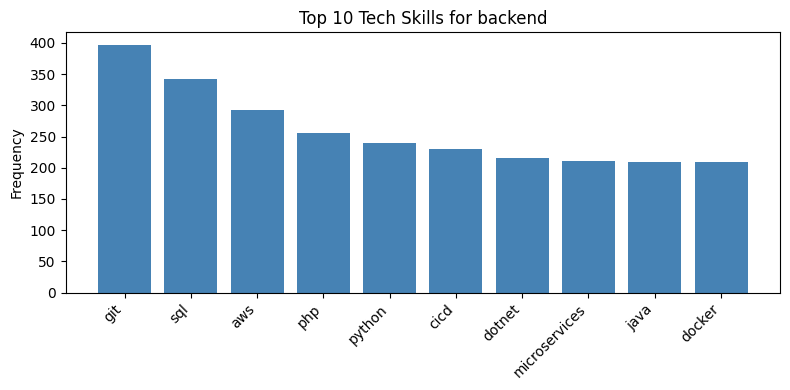

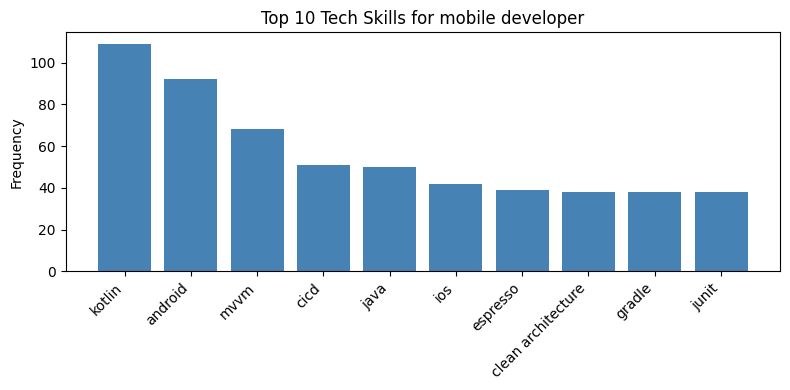

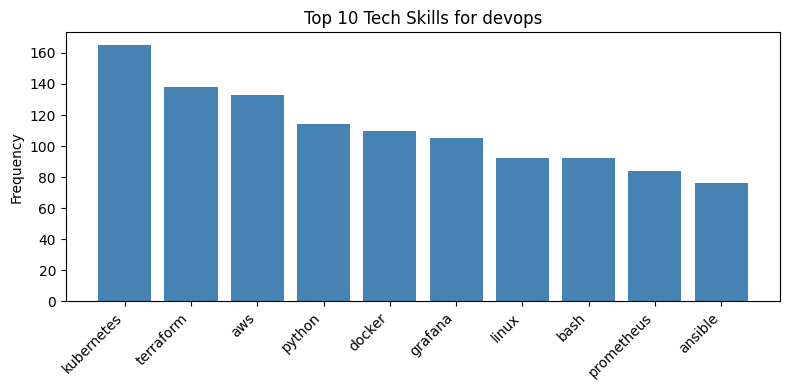

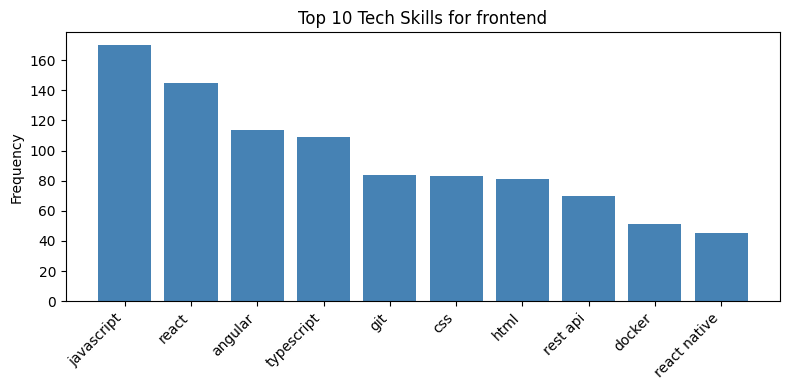

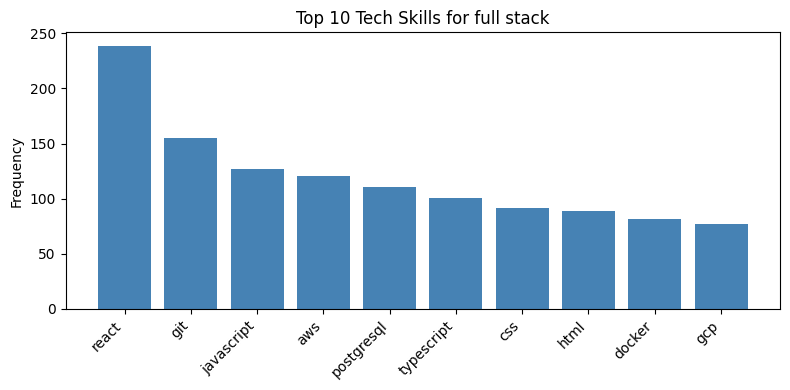

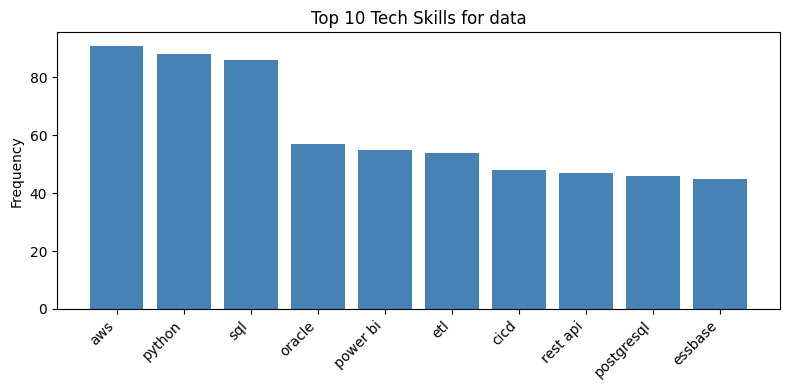

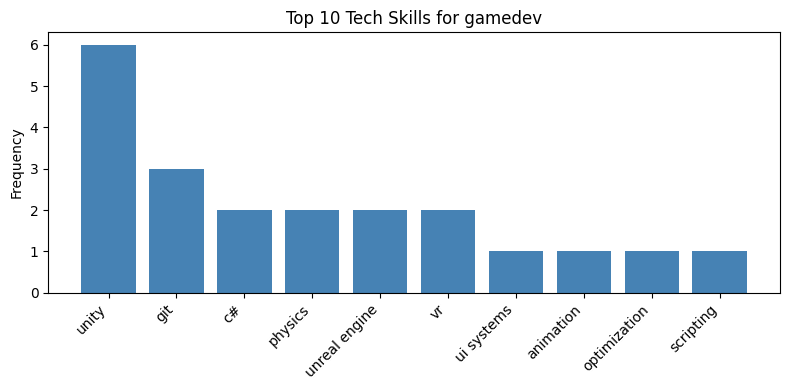

In [23]:
# Create DataFrame for tech skills counts
# Plot tech skills (top 10 per job)
for job in filtered_df['generic_title'].unique():
    tech_counts = tech_data[job].most_common(10)
    if tech_counts:
        skills, counts = zip(*tech_counts)
        plt.figure(figsize=(8, 4))
        plt.bar(skills, counts, color='steelblue')
        plt.title(f'Top 10 Tech Skills for {job}')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

# Plot soft skills (top 10 per job)
# for job in filtered_df['generic_title'].unique():
#     soft_counts = soft_data[job].most_common(10)
#     if soft_counts:
#         skills, counts = zip(*soft_counts)
#         plt.figure(figsize=(8, 4))
#         plt.bar(skills, counts, color='indianred')
#         plt.title(f'Top 10 Soft Skills for {job}')
#         plt.xticks(rotation=45, ha='right')
#         plt.ylabel('Frequency')
#         plt.tight_layout()
#         plt.show()


## Hard skills table

In [24]:
# Display
# print("\n=== Top 25 Tech Skills per Job ===")
display(tech_ranked_df)

backend         mobile developer               devops  \
Rank 1             git (397)             kotlin (109)     kubernetes (165)   
Rank 2             sql (342)             android (92)      terraform (138)   
Rank 3             aws (293)                mvvm (68)            aws (133)   
Rank 4             php (255)                cicd (51)         python (114)   
Rank 5          python (240)                java (50)         docker (110)   
Rank 6            cicd (230)                 ios (42)        grafana (105)   
Rank 7          dotnet (216)            espresso (39)           linux (92)   
Rank 8   microservices (211)  clean architecture (38)            bash (92)   
Rank 9            java (210)              gradle (38)      prometheus (84)   
Rank 10         docker (209)               junit (38)         ansible (76)   
Rank 11          azure (175)               swift (35)           azure (73)   
Rank 12          mysql (164)             swiftui (33)         jenkins (70)   
Rank 13     javascript (161)                 aws (32)            cicd (61)   
Rank 14         golang (147)               react (32)  cloudformation (43)   
Rank 15           rest (137)          kubernetes (32)         windows (41)   
Rank 16        laravel (128)           terraform (32)      postgresql (39)   
Rank 17     postgresql (125)             flutter (30)           mysql (38)   
Rank 18          kafka (122)                http (29)      powershell (33)   
Rank 19            gcp (113)          websockets (28)       sonarqube (31)   
Rank 20         csharp (110)               oauth (27)     artifactory (29)   
Rank 21  elasticsearch (106)              docker (24)          gitlab (28)   
Rank 22           nosql (98)               agile (22)             elk (24)   
Rank 23    restful apis (96)               scrum (21)             gcp (24)   
Rank 24         symfony (93)     jetpack compose (20)           kafka (22)   
Rank 25          spring (93)                 aes (18)          consul (22)   

                     frontend        full stack                   data  \
Rank 1       javascript (170)       react (239)               aws (91)   
Rank 2            react (145)         git (155)            python (88)   
Rank 3          angular (114)  javascript (127)               sql (86)   
Rank 4       typescript (109)         aws (121)            oracle (57)   
Rank 5               git (84)  postgresql (111)          power bi (55)   
Rank 6               css (83)  typescript (101)               etl (54)   
Rank 7              html (81)          css (92)              cicd (48)   
Rank 8          rest api (70)         html (89)          rest api (47)   
Rank 9            docker (51)       docker (82)        postgresql (46)   
Rank 10     react native (45)          gcp (77)           essbase (45)   
Rank 11              vue (44)      mongodb (75)               erp (45)   
Rank 12          node.js (37)      next.js (75)           tableau (41)   
Rank 13        socket.io (37)        azure (68)               git (33)   
Rank 14            azure (33)       nodejs (65)               oic (32)   
Rank 15             vite (30)      graphql (52)               epm (31)   
Rank 16             sass (28)         cicd (49)     data modeling (30)   
Rank 17       kubernetes (28)      node.js (49)  data warehousing (29)   
Rank 18            typo3 (26)          sql (40)            docker (29)   
Rank 19       typoscript (26)      nest.js (40)  microsoft office (28)   
Rank 20             scss (26)       dotnet (34)      aws redshift (27)   
Rank 21           github (26)         java (34)        clickhouse (26)   
Rank 22  version control (24)      express (34)         smartview (26)   
Rank 23            ux/ui (23)       spring (33)             nosql (23)   
Rank 24            figma (22)  spring boot (32)             spark (22)   
Rank 25             cicd (18)    terraform (28)        databricks (20)   

                       gamedev  
Rank 1               unity (6)  
R

## Soft skills table

In [25]:
# print("\n=== Top 25 Soft Skills per Job ===")
# display(soft_ranked_df)

## Job positions open

/tmp/ipykernel_85633/1874332190.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(job_date_counts))


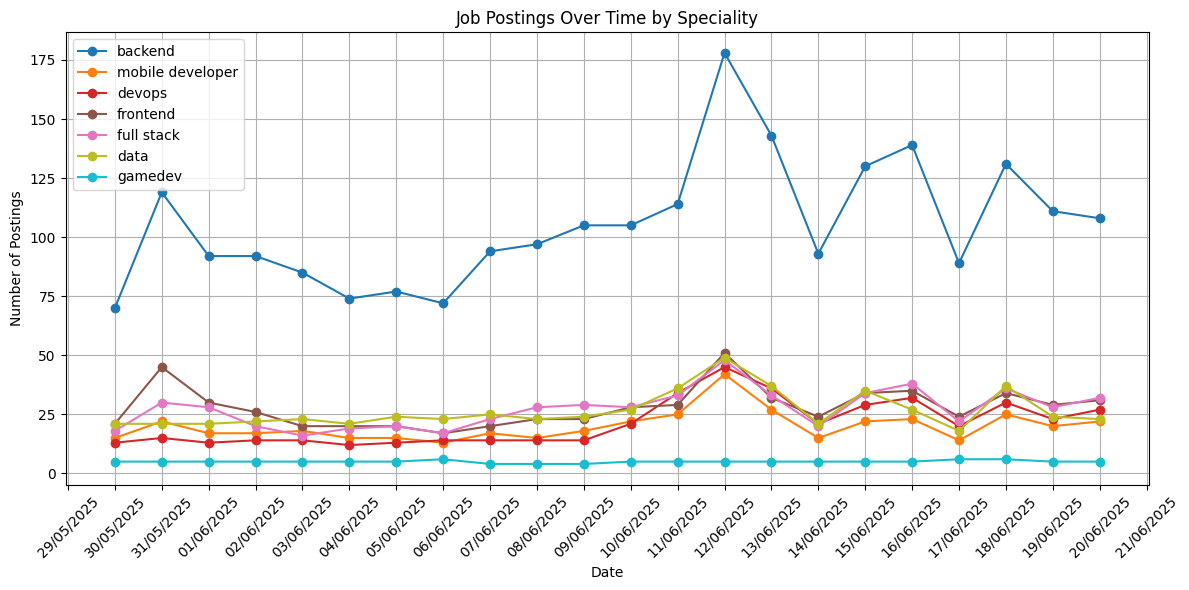

In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict
from utils import parse_date

# Prepare dictionary: {job_title: Counter({date: count})}
job_date_counts = defaultdict(Counter)

# Iterate through rows to populate job_date_counts
for _, row in filtered_df.iterrows():
    job = row['generic_title']
    occurrences = row['occurrences']
    if not occurrences:
        continue
    if isinstance(occurrences, str):
        occurrences = [occurrences]
    for date_str in occurrences:
        date = parse_date(date_str)
        if date:
            job_date_counts[job][date] += 1

# Plot
plt.figure(figsize=(12, 6))

# Choose distinct colors automatically
colors = plt.cm.get_cmap('tab10', len(job_date_counts))

for i, (job, date_counter) in enumerate(job_date_counts.items()):
    sorted_dates = sorted(date_counter.items())
    if not sorted_dates:
        continue
    dates, counts = zip(*sorted_dates)
    plt.plot(dates, counts, label=job, color=colors(i), marker='o')

# Formatting
plt.title("Job Postings Over Time by Speciality")
plt.xlabel("Date")
plt.ylabel("Number of Postings")
plt.grid(True)
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Most common occurences of keywords

## Responsabilities

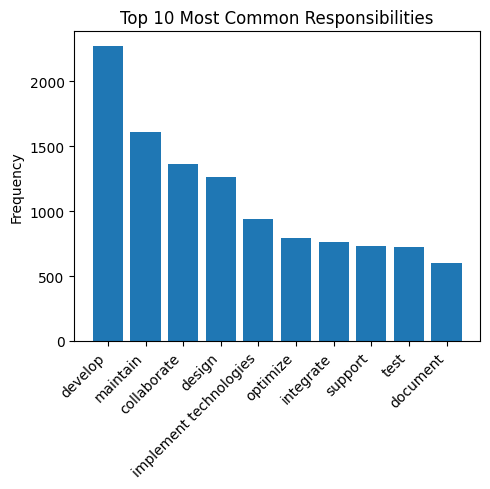

Full list of consolidated responsibilities term frequencies:

develop              2273
maintain             1614
collaborate          1363
design               1266
implement technologies 938
optimize             792
integrate            760
support              729
test                 726
document             603
manage               515
monitor              424
analyze              401
troubleshoot         398
improve              349
debug                332
deploy               332
review               304
build                207
lead                 204
ensure               179
deliver              177
resolve              170
mentor               162
create test cases    162
configure            155
research             149
scale                144
participate          139
write                126
automate             123
evaluate             122
identify             121
coordinate           116
generate             113
plan                 106
edit                 103
share  

In [27]:
tech_counts, tech_clusters = analyze_and_visualize_consolidated_terms(df, 'responsibilities', similarity_threshold=0.34, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

## Hard Skills

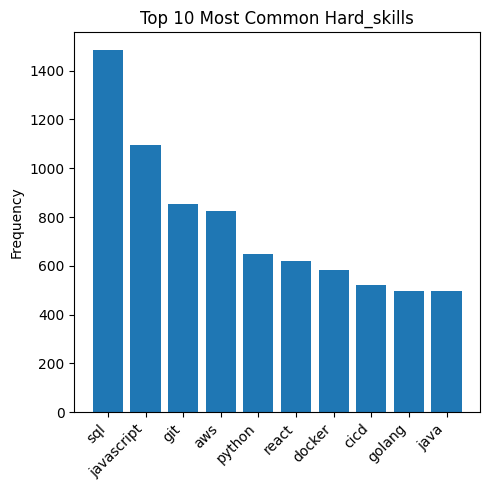

Full list of consolidated hard_skills term frequencies:

sql                  1483
javascript           1097
git                  852
aws                  825
python               649
react                618
docker               582
cicd                 522
golang               497
java                 496
rest                 460
postgresql           426
linux                406
web services         403
kubernetes           402
css                  402
html                 396
azure                393
dotnet               377
php                  341
spring boot          305
terraform            267
gcp                  240
kafka                235
nodejs               233
oracle               222
mongodb              217
microsoft office     217
sql server           205
android              203
cypress              183
kotlin               164
laravel              155
oop                  152
jenkins              150
google cloud         149
nagios               147
restful api     

In [28]:
tech_counts, tech_clusters = analyze_and_visualize_consolidated_terms(df, 'hard_skills', similarity_threshold=0.34, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

### v2

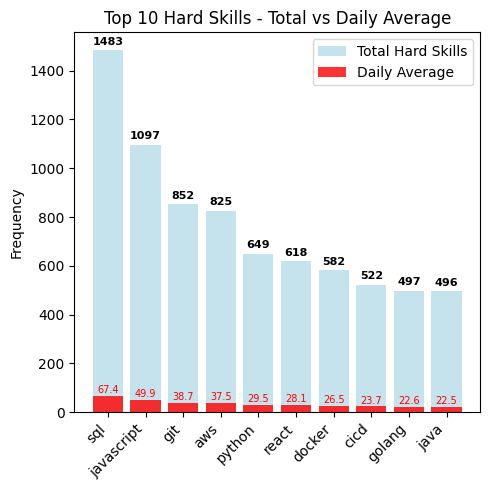

In [29]:
benefits_counts, benefits_clusters, daily_avg = analyze_and_visualize_consolidated_terms_v2(
    df, 'hard_skills', 
    similarity_threshold=0.34, 
    n=2, 
    top_n=10, 
    figsize=(5, 5), 
    rotation=45, 
    show_details=True,
    show_daily_average=True,  # Enable daily average calculation
    silent=True
)

## Soft Skills

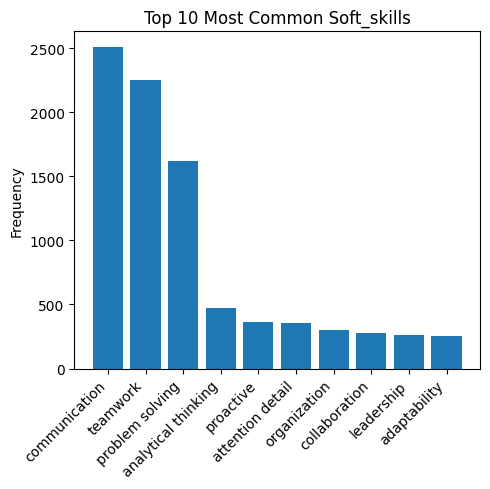

Full list of consolidated soft_skills term frequencies:

communication        2505
teamwork             2251
problem solving      1618
analytical thinking  471
proactive            364
attention detail     358
organization         297
collaboration        275
leadership           263
adaptability         251
motivated            195
creativity           145
responsibility       130
learning             130
detail oriented      119
independence         106
fast learner         92
initiative           87
flexibility          69
time management      55
interpersonal        52
growth mindset       49
negotiation          45
curiosity            45
documentation        41
results-focused      41
strategic thinking   33
analysis             28
multitasking         27
diligence            27
research             25
mentorship           24
flexible thinking    24
listening            20
autonomous           19
discipline           18
ambition             17
results-oriented     17
planning    

In [30]:
soft_counts, soft_clusters = analyze_and_visualize_consolidated_terms(df, 'soft_skills', similarity_threshold=0.4, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

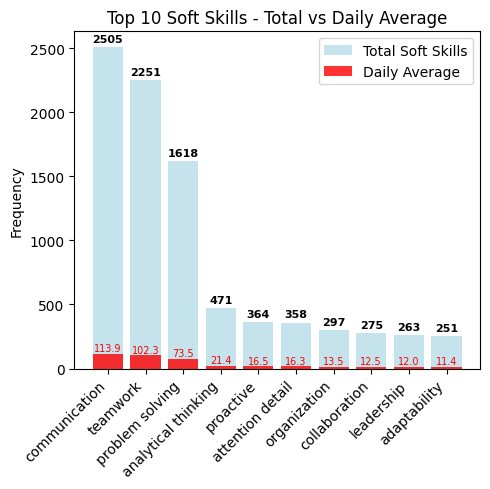

In [31]:
benefits_counts, benefits_clusters, daily_avg = analyze_and_visualize_consolidated_terms_v2(
    df, 'soft_skills', 
    similarity_threshold=0.4, 
    n=2, 
    top_n=10, 
    figsize=(5, 5), 
    rotation=45, 
    show_details=True,
    show_daily_average=True,  # Enable daily average calculation
    silent=True
)

## Benefits

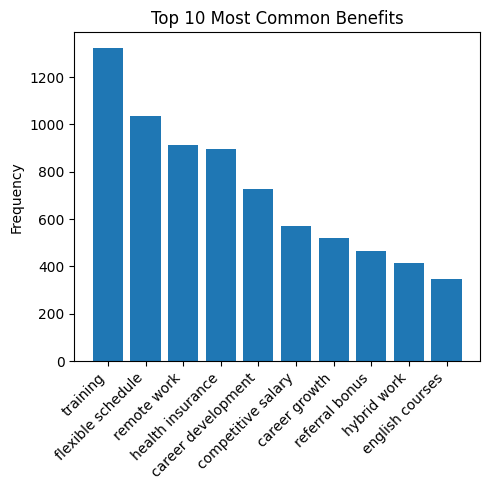

Full list of consolidated benefits term frequencies:

training             1323
flexible schedule    1036
remote work          915
health insurance     897
career development   729
competitive salary   571
career growth        520
referral bonus       465
hybrid work          414
english courses      345
paid vacation        320
professional growth  239
team building        227
language classes     225
corporate gifts      208
transport            153
growth opportunities 150
social package       142
sports compensation  126
comprehensive benefits 121
sick leave           117
education bonuses    114
paid lunch           98
modern office        98
work-life balance    94
birthday certificate 93
friendly team        87
unlimited pto        87
childcare budget     70
medical reimbursement 69
wellbeing programme  64
maternity leave      63
fitness discounts    62
continuous learning  62
equipment            59
gym membership       59
share plan           55
meal tickets         53
paid ho

In [32]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'benefits', similarity_threshold=0.3, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

### v2

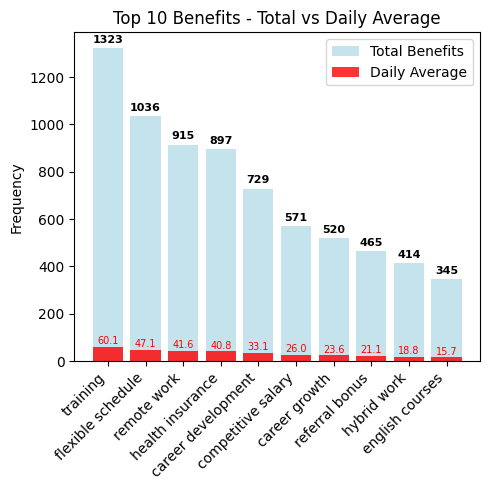

In [33]:
benefits_counts, benefits_clusters, daily_avg = analyze_and_visualize_consolidated_terms_v2(
    df, 'benefits', 
    similarity_threshold=0.3, 
    n=2, 
    top_n=10, 
    figsize=(5, 5), 
    rotation=45, 
    show_details=True,
    show_daily_average=True,  # Enable daily average calculation
    silent=True
)

## Languages

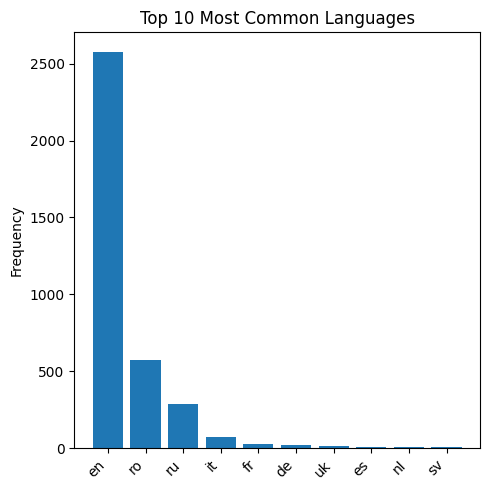

Full list of consolidated languages term frequencies:

en                   2575
ro                   571
ru                   289
it                   69
fr                   28
de                   21
uk                   14
es                   6
nl                   4
sv                   4
mandarin             3

Consolidation details:


In [34]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'languages', similarity_threshold=0.3, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

## Education

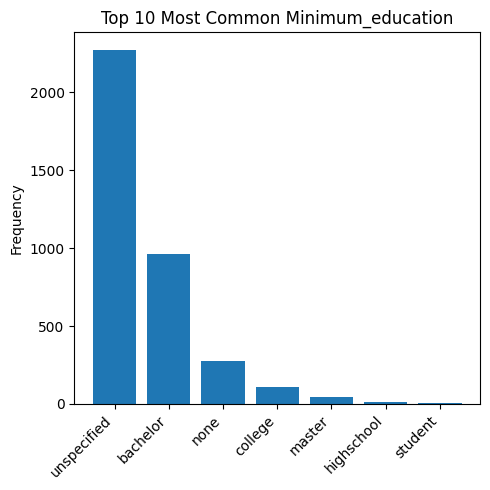

Full list of consolidated minimum_education term frequencies:

unspecified          2271
bachelor             962
none                 273
college              109
master               48
highschool           13
student              5

Consolidation details:


In [35]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'minimum_education', similarity_threshold=0.3, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

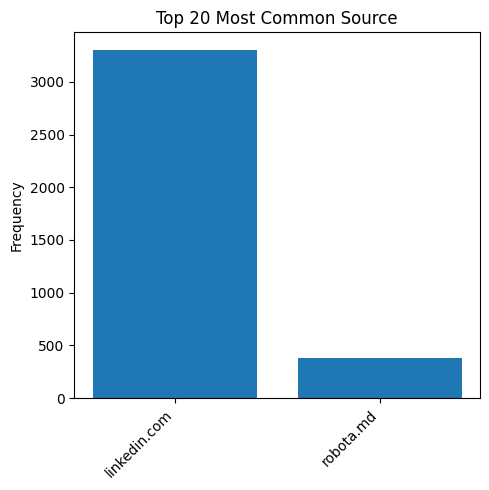

Full list of consolidated source term frequencies:

linkedin.com         3305
robota.md            376

Consolidation details:


In [36]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'source', similarity_threshold=0.5, n=2, top_n=20, 
                                     figsize=(5, 5), rotation=45, show_details=True)

## Company Name

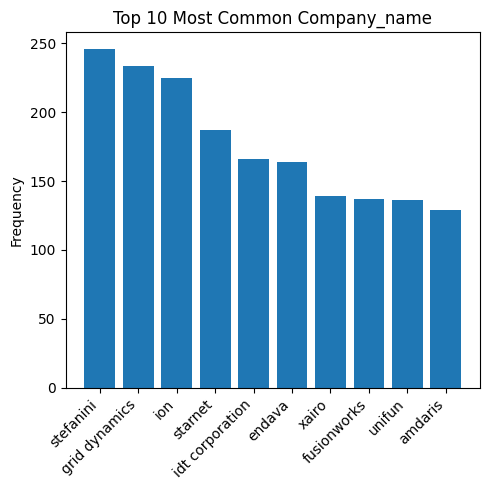

Full list of consolidated company_name term frequencies:

stefanini            246
grid dynamics        234
ion                  225
starnet              187
idt corporation      166
endava               164
xairo                139
fusionworks          137
unifun               136
amdaris              129
kivork               111
gilat satellite networks 76
mixbook              75
createq              75
infuse               74
plummy games         71
insomniac design     53
capslock             48
appsfactory          43
ruby labs            39
dyninno              38
national bank of moldova 38
mindrift             35
maib                 33
extole               31
orange systems       30
gr8 tech             29
backstageit          27
elbackup             27
developmentaid       24
glovo                22
paynet               20
threecolts           19
ymk it management    19
yopeso               19
nexusweb             19
bairesdev            17
fyst                 17
estem      

In [37]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'company_name', similarity_threshold=0.5, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

### v2

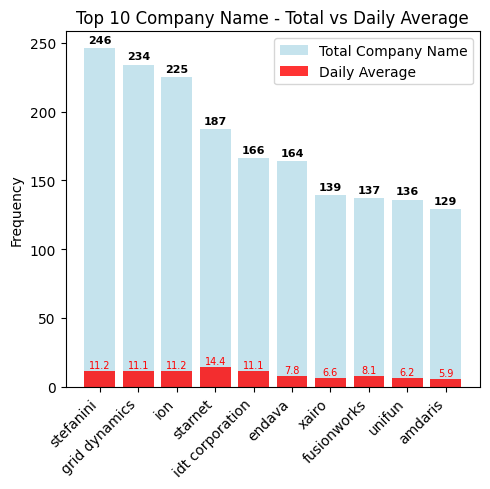

In [38]:
benefits_counts, benefits_clusters, daily_avg = analyze_and_visualize_consolidated_terms_v2(
    df, 'company_name', 
    similarity_threshold=0.5, 
    n=2, 
    top_n=10, 
    figsize=(5, 5), 
    rotation=45, 
    show_details=True,
    show_daily_average=True,  # Enable daily average calculation
    silent=True
)

## Company Size

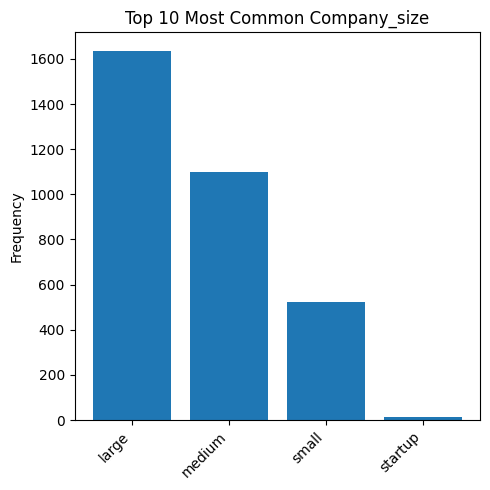

Full list of consolidated company_size term frequencies:

large                1636
medium               1100
small                524
startup              14

Consolidation details:


In [39]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'company_size', similarity_threshold=0.4, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

### Company Size Skills Required

In [40]:
import pandas as pd
from collections import Counter

# Filter rows where company_size is available
filtered_df = df[df['company_size'].notna()]

# Store counts per company size
skill_data = {}

for size in filtered_df['company_size'].unique():
    subset = filtered_df[filtered_df['company_size'] == size]
    
    skills = [skill for skills_list in subset['hard_skills'].dropna() 
              for skill in (skills_list if isinstance(skills_list, list) else [skills_list])]
    
    skill_counts = Counter(skills)
    skill_data[size] = skill_counts

# Build ranked table: rows = Rank 1..N, columns = company sizes
def build_ranked_df(skill_data, top_n=10):
    sizes = list(skill_data.keys())
    ranked_dict = {size: [] for size in sizes}
    
    for size in sizes:
        top_skills = skill_data[size].most_common(top_n)
        ranked_dict[size] = [f"{skill} ({count})" for skill, count in top_skills]
        
        # Pad with empty strings
        if len(ranked_dict[size]) < top_n:
            ranked_dict[size].extend([''] * (top_n - len(ranked_dict[size])))
    
    ranked_df = pd.DataFrame(ranked_dict, index=[f"Rank {i+1}" for i in range(top_n)])
    return ranked_df

# Generate and show the ranked DataFrame
hard_skills_ranked_df = build_ranked_df(skill_data, top_n=15)
hard_skills_ranked_df


large              medium          startup  \
Rank 1          sql (442)           sql (277)          git (9)   
Rank 2          aws (433)           aws (256)       python (9)   
Rank 3       python (396)           git (212)        pyqt5 (8)   
Rank 4         cicd (388)    postgresql (205)        pyqt6 (8)   
Rank 5   javascript (343)        docker (194)      tkinter (8)   
Rank 6          git (312)         linux (186)       pandas (8)   
Rank 7       docker (309)          java (179)     openpyxl (8)   
Rank 8         java (282)    kubernetes (176)           1c (8)   
Rank 9        azure (268)         mysql (172)  com interop (8)   
Rank 10      dotnet (254)        python (155)    wordpress (4)   
Rank 11         gcp (212)         react (133)         html (2)   
Rank 12      oracle (197)    typescript (109)          css (2)   
Rank 13        html (192)       android (105)          php (2)   
Rank 14       react (174)           php (104)  pyinstaller (2)   
Rank 15  sql server (173)  microservices (97)     frontend (1)   

                    small  
Rank 1        react (225)  
Rank 2   javascript (214)  
Rank 3          git (201)  
Rank 4          php (123)  
Rank 5          aws (110)  
Rank 6      laravel (107)  
Rank 7    typescript (94)  
Rank 8      rest api (93)  
Rank 9       angular (92)  
Rank 10        mysql (77)  
Rank 11       kotlin (66)  
Rank 12          css (62)  
Rank 13         html (61)  
Rank 14          sql (57)  
Rank 15       python (49)

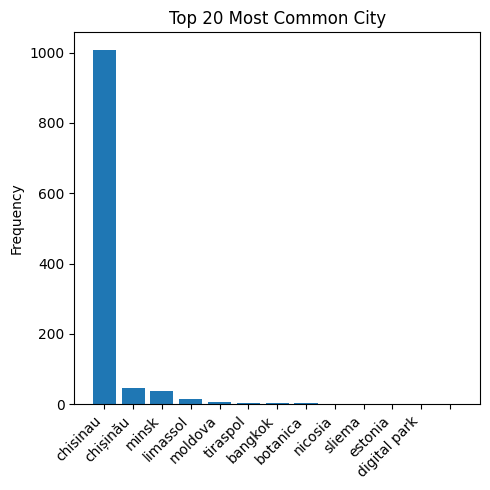

Full list of consolidated city term frequencies:

chisinau             1007
chișinău             46
minsk                37
limassol             14
moldova              7
tiraspol             5
bangkok              4
botanica             3
nicosia              2
sliema               1
estonia              1
digital park         1
                     1

Consolidation details:


In [41]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'city', similarity_threshold=0.4, n=2, top_n=20, 
                                     figsize=(5, 5), rotation=45, show_details=True)

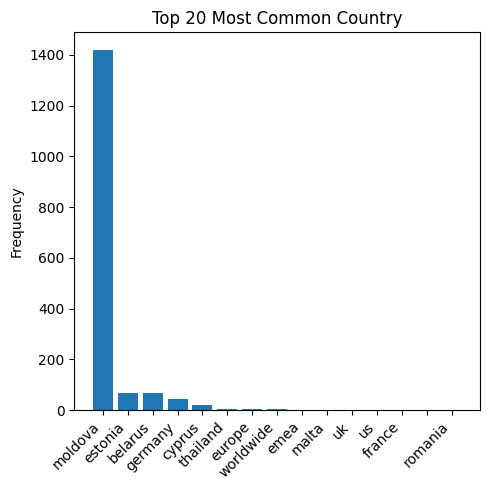

Full list of consolidated country term frequencies:

moldova              1418
estonia              69
belarus              66
germany              43
cyprus               22
thailand             6
europe               4
worldwide            3
emea                 1
malta                1
uk                   1
us                   1
france               1
                     1
romania              1

Consolidation details:
thailand (6): thailand, poland


In [42]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'country', similarity_threshold=0.3, n=2, top_n=20, 
                                     figsize=(5, 5), rotation=45, show_details=True)

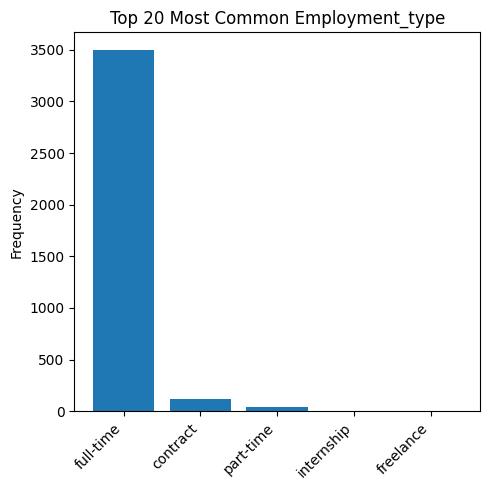

Full list of consolidated employment_type term frequencies:

full-time            3495
contract             116
part-time            44
internship           6
freelance            3

Consolidation details:


In [43]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'employment_type', similarity_threshold=0.4, n=2, top_n=20, 
                                     figsize=(5, 5), rotation=45, show_details=True)

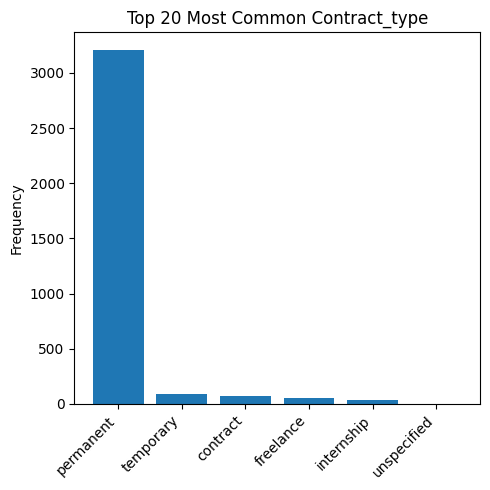

Full list of consolidated contract_type term frequencies:

permanent            3209
temporary            87
contract             76
freelance            57
internship           37
unspecified          1

Consolidation details:


In [44]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'contract_type', similarity_threshold=0.4, n=2, top_n=20, 
                                     figsize=(5, 5), rotation=45, show_details=True)

# Work Schedule

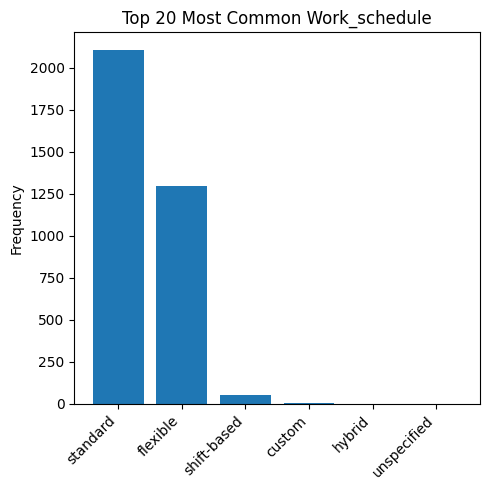

Full list of consolidated work_schedule term frequencies:

standard             2106
flexible             1298
shift-based          55
custom               3
hybrid               1
unspecified          1

Consolidation details:


In [45]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'work_schedule', similarity_threshold=0.4, n=2, top_n=20, 
                                     figsize=(5, 5), rotation=45, show_details=True)

### v2

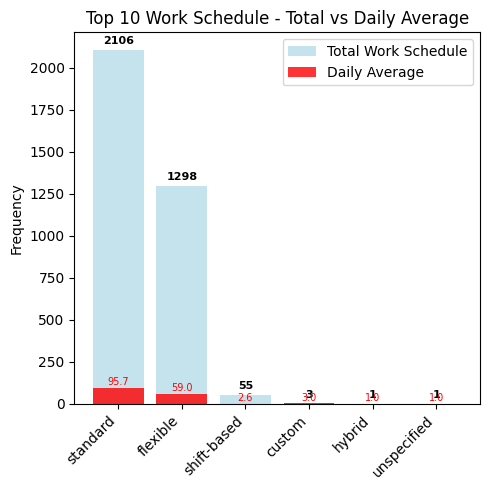

In [46]:
benefits_counts, benefits_clusters, daily_avg = analyze_and_visualize_consolidated_terms_v2(
    df, 'work_schedule', 
    similarity_threshold=0.4, 
    n=2, 
    top_n=10, 
    figsize=(5, 5), 
    rotation=45, 
    show_details=True,
    show_daily_average=True,  # Enable daily average calculation
    silent=True
)

# Remote Work

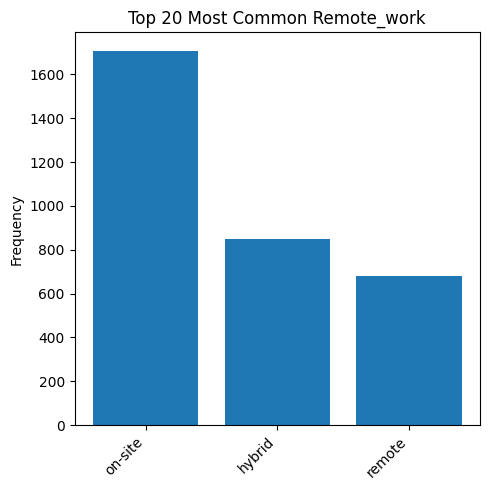

Full list of consolidated remote_work term frequencies:

on-site              1707
hybrid               849
remote               681

Consolidation details:


In [47]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'remote_work', similarity_threshold=0.3, n=2, top_n=20, 
                                     figsize=(5, 5), rotation=45, show_details=True)

### v2

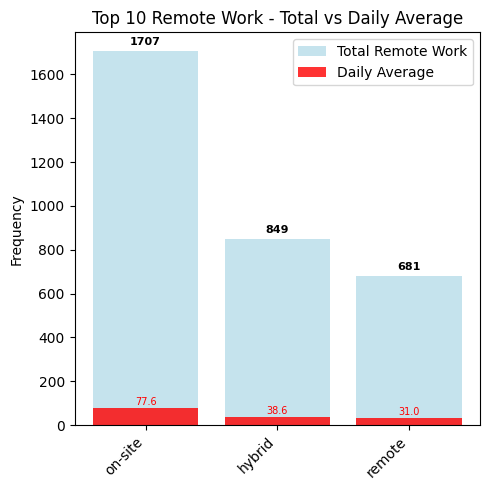

In [48]:
benefits_counts, benefits_clusters, daily_avg = analyze_and_visualize_consolidated_terms_v2(
    df, 'remote_work', 
    similarity_threshold=0.3, 
    n=2, 
    top_n=10, 
    figsize=(5, 5), 
    rotation=45, 
    show_details=True,
    show_daily_average=True,  # Enable daily average calculation
    silent=True
)

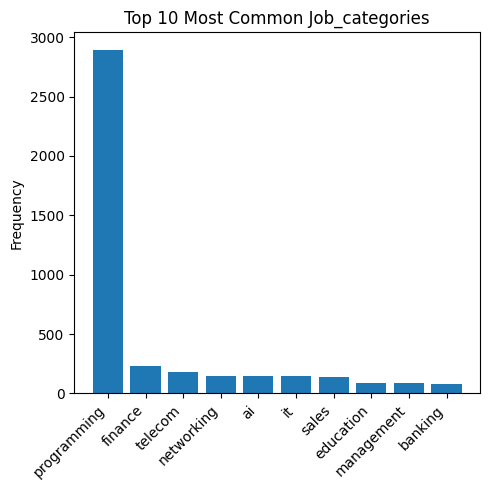

Full list of consolidated job_categories term frequencies:

programming          2896
finance              228
telecom              177
networking           149
ai                   147
it                   144
sales                138
education            89
management           89
banking              83
data                 77
fintech              62
it support           56
video editing        56
cyber security       48
it services          47
system administration 43
qa                   43
e-learning           40
design               37
automotive           36
cloud                35
business             32
real estate          31
hr                   30
engineering          29
consulting           27
travel               25
ecommerce            25
analysis             22
devops               21
web development      20
investment           17
technology           16
testing              14
renewable energy     13
construction         11
economics            9
accounting          

In [49]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'job_categories', similarity_threshold=0.3, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

# Salary Currency

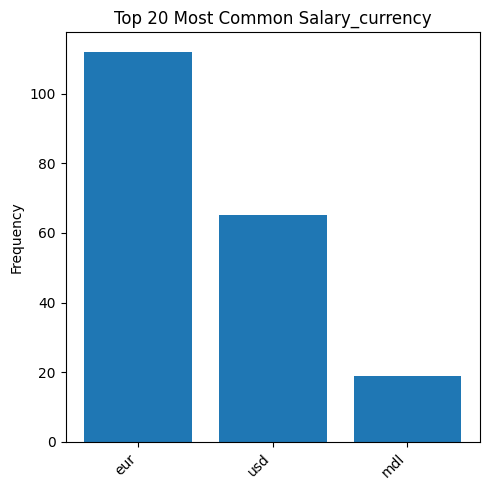

Full list of consolidated salary_currency term frequencies:

eur                  112
usd                  65
mdl                  19

Consolidation details:


In [50]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'salary_currency', similarity_threshold=0.3, n=2, top_n=20, 
                                     figsize=(5, 5), rotation=45, show_details=True)

# Experience Distribution

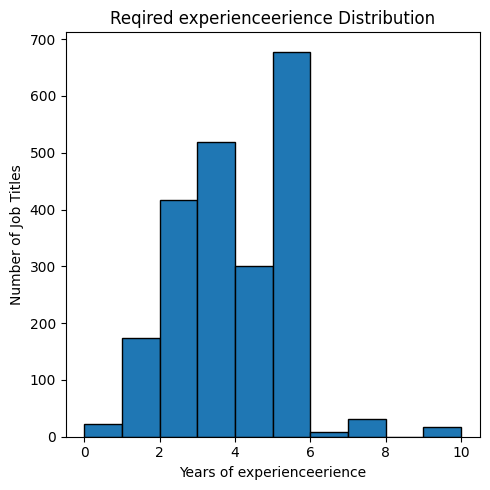

experienceerience Stats (After Dropping NaN):

count    2168.000000
mean        3.504151
std         1.547877
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        10.000000
Name: experience, dtype: float64


In [51]:
df['experience'] = pd.to_numeric(df['experience'], errors='coerce')
df_clean = df.dropna(subset=['experience'])

# Plot experienceerience distribution
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(df_clean['experience'], bins=range(int(df_clean['experience'].min()), int(df_clean['experience'].max()) + 1), edgecolor='black')
ax.set_title('Reqired experienceerience Distribution')
ax.set_xlabel('Years of experienceerience')
ax.set_ylabel('Number of Job Titles')
plt.tight_layout()
plt.show()

# Print experienceerience stats for cleaned data
print("experienceerience Stats (After Dropping NaN):\n")
print(df_clean['experience'].describe())


# Salary distribution

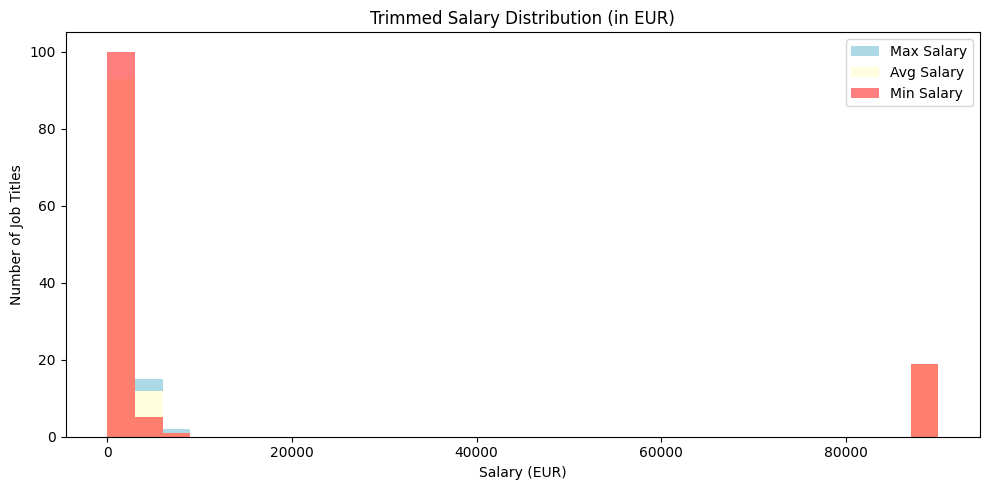

Salary Stats (on 125 salaries) (in EUR, After Conversion & Trimming):

       salary_min_eur  salary_avg_eur  salary_max_eur
count      125.000000      125.000000       125.00000
mean     15068.627680    15324.331680     15580.03568
std      31867.210947    31760.235024     31655.13249
min          6.160000       19.360000        22.00000
25%       1200.000000     1402.500000      1584.00000
50%       1500.000000     2000.000000      2500.00000
75%       2640.000000     3250.000000      3500.00000
max      90000.000000    90000.000000     90000.00000


In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `df` is already loaded

# Conversion rates to EUR
currency_rates = {
    'usd': 0.88,
    'mdl': 0.051,
    'eur': 1.0,
    'gbp': 1.17
}

# Function to convert salary to EUR
def convert_to_eur(row):
    currency = (row.get('salary_currency') or '').lower()
    rate = currency_rates.get(currency)
    
    if rate and pd.notnull(row.get('min_salary')):
        min_salary_eur = row['min_salary'] * rate
        max_salary = row.get('max_salary')
        max_salary_eur = max_salary * rate if pd.notnull(max_salary) else None
    else:
        min_salary_eur = max_salary_eur = None
    
    return pd.Series([min_salary_eur, max_salary_eur])

# Convert salaries to EUR
df[['salary_min_eur', 'salary_max_eur']] = df.apply(convert_to_eur, axis=1)
df_clean = df.dropna(subset=['salary_min_eur', 'salary_max_eur']).copy()
df_clean['salary_avg_eur'] = (df_clean['salary_min_eur'] + df_clean['salary_max_eur']) / 2

# Sort and trim top/bottom 3 in each salary column
def trim_outliers(df, column, n=3, m=3):
    return df.sort_values(by=column).iloc[n:-m]

df_trimmed = df_clean.copy()
# for col in ['salary_min_eur', 'salary_avg_eur', 'salary_max_eur']:
#     df_trimmed = trim_outliers(df_trimmed, col, 3, 6)

# Plot salary distributions (trimmed)
plt.figure(figsize=(10, 5))
plt.hist(df_trimmed['salary_max_eur'], bins=30, alpha=1, label='Max Salary', color='lightblue')
plt.hist(df_trimmed['salary_avg_eur'], bins=30, alpha=1, label='Avg Salary', color='lightyellow')
plt.hist(df_trimmed['salary_min_eur'], bins=30, alpha=0.5, label='Min Salary', color='red')
plt.title('Trimmed Salary Distribution (in EUR)')
plt.xlabel('Salary (EUR)')
plt.ylabel('Number of Job Titles')
plt.legend()
plt.tight_layout()
plt.show()

# Print salary stats (trimmed)
print(f"Salary Stats (on {len(df_trimmed)} salaries) (in EUR, After Conversion & Trimming):\n")
print(df_trimmed[['salary_min_eur', 'salary_avg_eur', 'salary_max_eur']].describe())


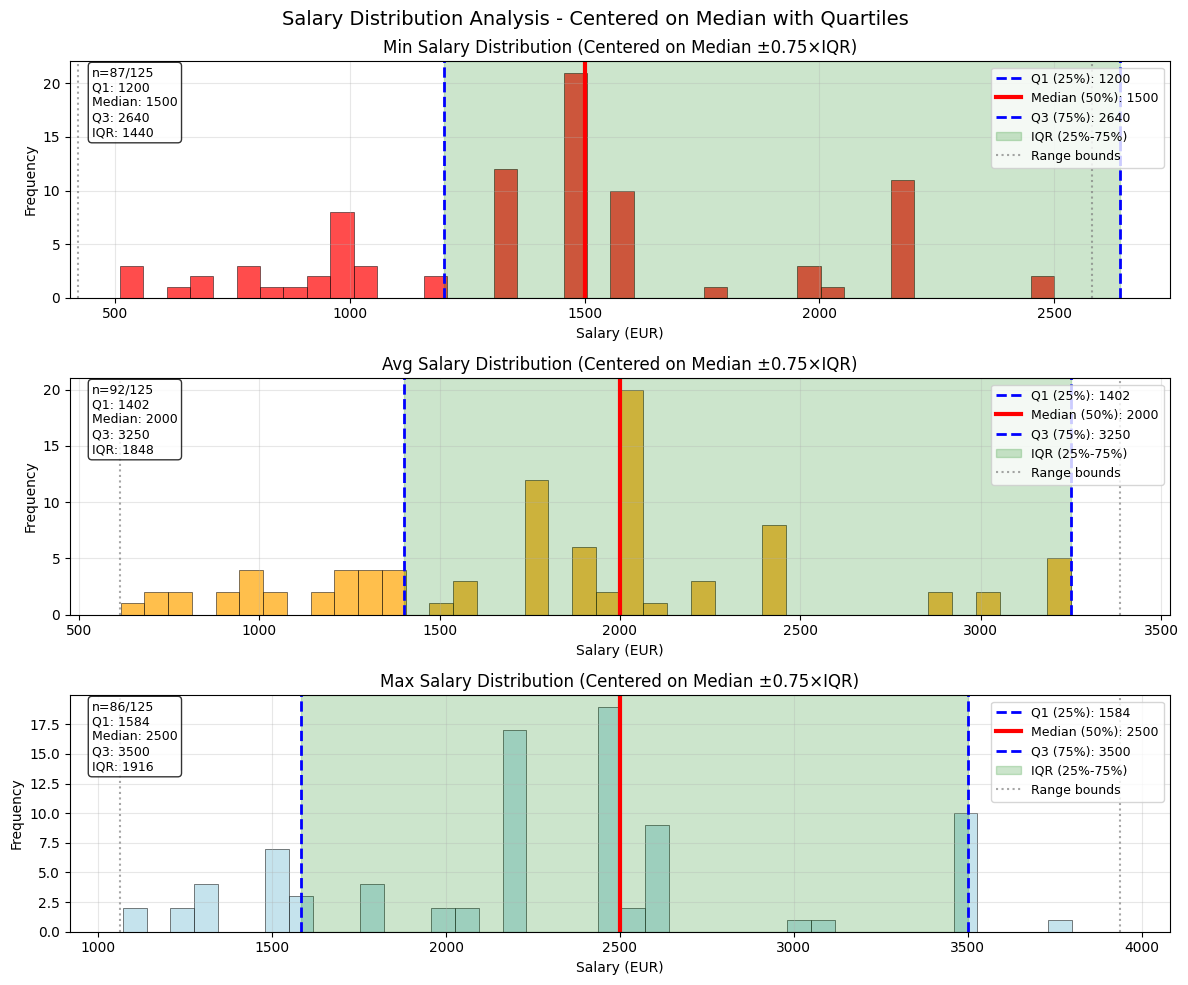

SALARY DISTRIBUTION SUMMARY (PERCENTILE-BASED)

Min Salary:
  Total samples: 125
  Samples in range: 103 (82.4%)
  Q1 (25th percentile): 1200 EUR
  Median (50th percentile): 1500 EUR
  Q3 (75th percentile): 2640 EUR
  IQR (Q3-Q1): 1440 EUR
  Range shown: -660 to 3660 EUR
  Outliers excluded: 22

Avg Salary:
  Total samples: 125
  Samples in range: 104 (83.2%)
  Q1 (25th percentile): 1402 EUR
  Median (50th percentile): 2000 EUR
  Q3 (75th percentile): 3250 EUR
  IQR (Q3-Q1): 1848 EUR
  Range shown: -771 to 4771 EUR
  Outliers excluded: 21

Max Salary:
  Total samples: 125
  Samples in range: 104 (83.2%)
  Q1 (25th percentile): 1584 EUR
  Median (50th percentile): 2500 EUR
  Q3 (75th percentile): 3500 EUR
  IQR (Q3-Q1): 1916 EUR
  Range shown: -374 to 5374 EUR
  Outliers excluded: 21


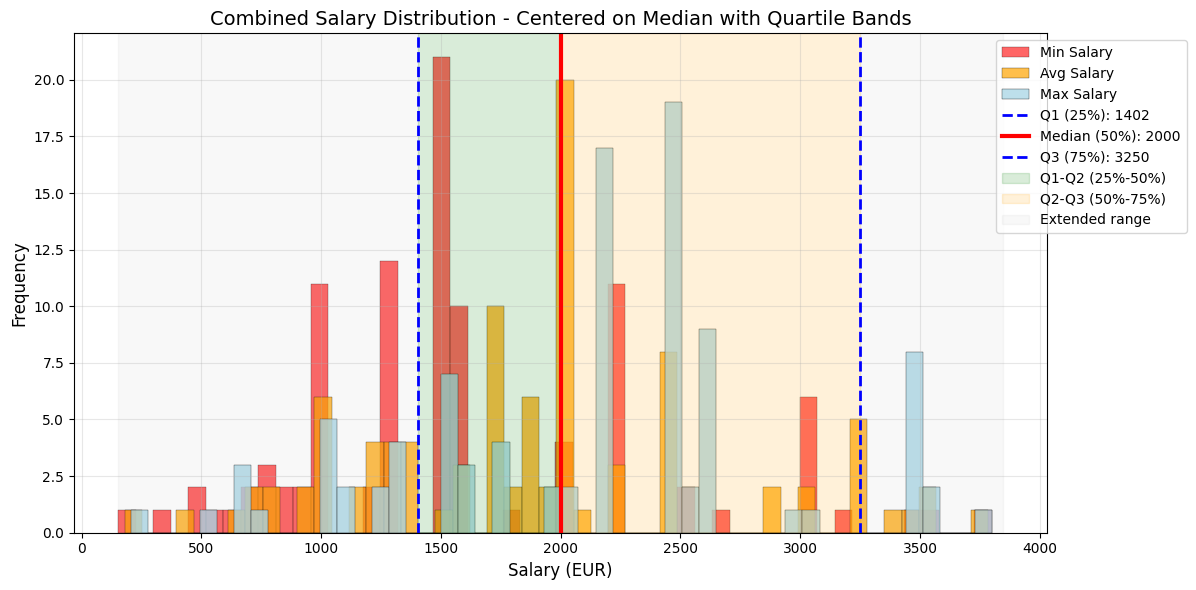

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ZOOM LEVEL CONFIGURATION
ZOOM_LEVEL = 0.75  # Adjust this value to zoom in/out (lower = more zoomed in)
COMBINED_ZOOM_LEVEL = 1  # Zoom level for the combined plot

# Assuming `df` is already loaded
# Conversion rates to EUR
currency_rates = {
    'usd': 0.88,
    'mdl': 0.051,
    'eur': 1.0,
    'gbp': 1.17
}

# Function to convert salary to EUR
def convert_to_eur(row):
    currency = (row.get('salary_currency') or '').lower()
    rate = currency_rates.get(currency)
    if rate and pd.notnull(row.get('min_salary')):
        min_salary_eur = row['min_salary'] * rate
        max_salary = row.get('max_salary')
        max_salary_eur = max_salary * rate if pd.notnull(max_salary) else None
    else:
        min_salary_eur = max_salary_eur = None
    return pd.Series([min_salary_eur, max_salary_eur])

# Convert salaries to EUR
df[['salary_min_eur', 'salary_max_eur']] = df.apply(convert_to_eur, axis=1)
df_clean = df.dropna(subset=['salary_min_eur', 'salary_max_eur']).copy()
df_clean['salary_avg_eur'] = (df_clean['salary_min_eur'] + df_clean['salary_max_eur']) / 2

# Function to get percentile-based range
def get_percentile_range(data, center_percentile=50, range_multiplier=3):
    """
    Get range based on percentiles, centered around median
    Uses IQR (Interquartile Range) for robust range calculation
    """
    q25 = data.quantile(0.25)
    q50 = data.quantile(0.50)  # median
    q75 = data.quantile(0.75)
    
    iqr = q75 - q25  # Interquartile Range
    
    # Center around median, extend by range_multiplier * IQR
    lower_bound = q50 - (range_multiplier * iqr)
    upper_bound = q50 + (range_multiplier * iqr)
    
    return lower_bound, upper_bound, q25, q50, q75, iqr

# Create subplot for all three salary types
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
salary_columns = ['salary_min_eur', 'salary_avg_eur', 'salary_max_eur']
colors = ['red', 'orange', 'lightblue']
labels = ['Min Salary', 'Avg Salary', 'Max Salary']

for i, (col, color, label) in enumerate(zip(salary_columns, colors, labels)):
    data = df_clean[col]
    
    # Get percentile-based range (centered on median)
    lower_bound, upper_bound, q25, q50, q75, iqr = get_percentile_range(data, range_multiplier=ZOOM_LEVEL)
    
    # Filter data to the centered range
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    
    # Plot histogram
    axes[i].hist(filtered_data, bins=40, alpha=0.7, color=color, edgecolor='black', linewidth=0.5)
    
    # Add vertical lines for quartiles
    axes[i].axvline(q25, color='blue', linestyle='--', linewidth=2, label=f'Q1 (25%): {q25:.0f}')
    axes[i].axvline(q50, color='red', linestyle='-', linewidth=3, label=f'Median (50%): {q50:.0f}')
    axes[i].axvline(q75, color='blue', linestyle='--', linewidth=2, label=f'Q3 (75%): {q75:.0f}')
    
    # Add IQR shading
    axes[i].axvspan(q25, q75, alpha=0.2, color='green', label='IQR (25%-75%)')
    
    # Add range boundaries
    axes[i].axvline(lower_bound, color='gray', linestyle=':', alpha=0.7, label='Range bounds')
    axes[i].axvline(upper_bound, color='gray', linestyle=':', alpha=0.7)
    
    # Set title and labels
    axes[i].set_title(f'{label} Distribution (Centered on Median ±{ZOOM_LEVEL}×IQR)', fontsize=12)
    axes[i].set_xlabel('Salary (EUR)')
    axes[i].set_ylabel('Frequency')
    axes[i].legend(loc='upper right', fontsize=9)
    axes[i].grid(True, alpha=0.3)
    
    # Add text box with statistics
    stats_text = f'n={len(filtered_data)}/{len(data)}\nQ1: {q25:.0f}\nMedian: {q50:.0f}\nQ3: {q75:.0f}\nIQR: {iqr:.0f}'
    axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=9)

plt.suptitle('Salary Distribution Analysis - Centered on Median with Quartiles', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

# Summary statistics
print("="*60)
print("SALARY DISTRIBUTION SUMMARY (PERCENTILE-BASED)")
print("="*60)

for col, label in zip(salary_columns, labels):
    data = df_clean[col]
    lower_bound, upper_bound, q25, q50, q75, iqr = get_percentile_range(data, range_multiplier=1.5)
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    
    print(f"\n{label}:")
    print(f"  Total samples: {len(data)}")
    print(f"  Samples in range: {len(filtered_data)} ({len(filtered_data)/len(data)*100:.1f}%)")
    print(f"  Q1 (25th percentile): {q25:.0f} EUR")
    print(f"  Median (50th percentile): {q50:.0f} EUR")
    print(f"  Q3 (75th percentile): {q75:.0f} EUR")
    print(f"  IQR (Q3-Q1): {iqr:.0f} EUR")
    print(f"  Range shown: {lower_bound:.0f} to {upper_bound:.0f} EUR")
    print(f"  Outliers excluded: {len(data) - len(filtered_data)}")

# Combined plot centered on median with quartile bands
plt.figure(figsize=(12, 6))

# Use average salary for the main analysis
main_data = df_clean['salary_avg_eur']
lower_bound, upper_bound, q25, q50, q75, iqr = get_percentile_range(main_data, range_multiplier=COMBINED_ZOOM_LEVEL)

# Filter all data to this range
for col, color, label, alpha in zip(salary_columns, ['red', 'orange', 'lightblue'], labels, [0.6, 0.7, 0.8]):
    filtered_data = df_clean[col][(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    plt.hist(filtered_data, bins=50, alpha=alpha, color=color, label=label, edgecolor='black', linewidth=0.3)

# Add quartile lines
plt.axvline(q25, color='blue', linestyle='--', linewidth=2, label=f'Q1 (25%): {q25:.0f}')
plt.axvline(q50, color='red', linestyle='-', linewidth=3, label=f'Median (50%): {q50:.0f}')
plt.axvline(q75, color='blue', linestyle='--', linewidth=2, label=f'Q3 (75%): {q75:.0f}')

# Add quartile bands
plt.axvspan(q25, q50, alpha=0.15, color='green', label='Q1-Q2 (25%-50%)')
plt.axvspan(q50, q75, alpha=0.15, color='orange', label='Q2-Q3 (50%-75%)')

# Add extended range indicators
plt.axvspan(q50 - iqr, q25, alpha=0.05, color='gray', label='Extended range')
plt.axvspan(q75, q50 + iqr, alpha=0.05, color='gray')

plt.title('Combined Salary Distribution - Centered on Median with Quartile Bands', fontsize=14)
plt.xlabel('Salary (EUR)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Salary Evolution Over Time

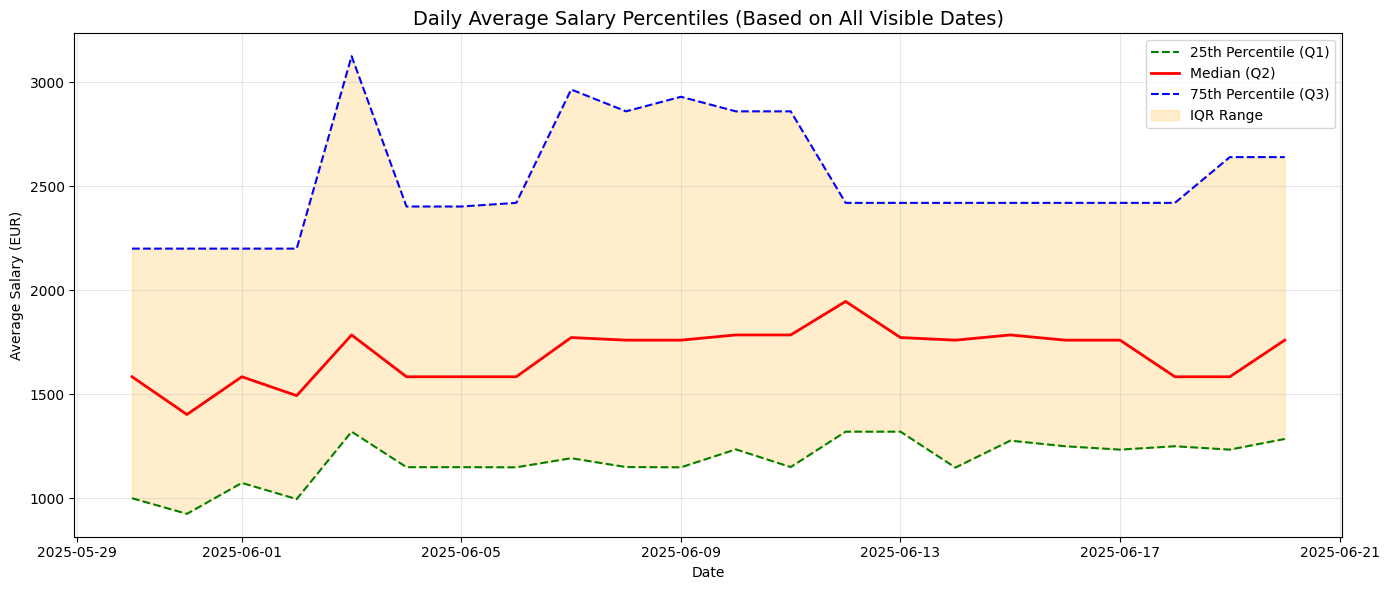

In [54]:
from collections import defaultdict

# Prepare a dictionary to collect salaries per visible date
date_to_salaries = defaultdict(list)

for idx, row in df_clean.iterrows():
    salary = row.get('salary_avg_eur')
    if pd.isnull(salary):
        continue
    
    # Collect all valid date entries
    dates_seen = set()
    
    # Add main date
    d = row.get('date')
    if pd.notnull(d):
        try:
            dates_seen.add(parse_date(d))
        except:
            pass
    
    # Add occurrences
    occ = row.get('occurrences')
    if occ:
        if not isinstance(occ, list):
            occ = [occ]
        for od in occ:
            try:
                if pd.notnull(od) and str(od).strip().lower() != 'nan':
                    dates_seen.add(parse_date(od))
            except:
                continue
    
    # Append salary to all valid dates
    for d in dates_seen:
        date_to_salaries[d].append(salary)

# Create DataFrame of percentiles
percentile_rows = []
for dt in sorted(date_to_salaries.keys()):
    salaries = date_to_salaries[dt]
    if len(salaries) >= 3:  # Require at least 3 samples for percentile calc
        q1 = np.percentile(salaries, 25)
        median = np.percentile(salaries, 50)
        q3 = np.percentile(salaries, 75)
        percentile_rows.append((dt, q1, median, q3))

percentile_df = pd.DataFrame(percentile_rows, columns=['date', 'Q1', 'Median', 'Q3'])
percentile_df = percentile_df.sort_values('date')

# Plot
plt.figure(figsize=(14, 6))
plt.plot(percentile_df['date'], percentile_df['Q1'], label='25th Percentile (Q1)', color='green', linestyle='--')
plt.plot(percentile_df['date'], percentile_df['Median'], label='Median (Q2)', color='red', linewidth=2)
plt.plot(percentile_df['date'], percentile_df['Q3'], label='75th Percentile (Q3)', color='blue', linestyle='--')
plt.fill_between(percentile_df['date'], percentile_df['Q1'], percentile_df['Q3'], color='orange', alpha=0.2, label='IQR Range')

plt.title("Daily Average Salary Percentiles (Based on All Visible Dates)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Average Salary (EUR)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Salary per specialization

In [55]:
df_clean_salaries = df_trimmed.copy()
filtered_df = df_clean_salaries[df_clean_salaries['generic_title'].notna()].copy()

# Analysis by job specialty
job_specialties = filtered_df['generic_title'].value_counts()
print("Job Specialties Distribution:")
for specialty, count in job_specialties.items():
    print(f"{specialty}: {count} positions")
print("\n" + "="*80 + "\n")

# Create salary analysis for each specialty with sufficient data (at least 3 positions)
min_positions = 3
specialties_with_data = job_specialties[job_specialties >= min_positions].index

# Calculate stats for each specialty
specialty_stats = {}
for specialty in specialties_with_data:
    specialty_data = filtered_df[filtered_df['generic_title'] == specialty]
    specialty_stats[specialty] = specialty_data[['salary_min_eur', 'salary_avg_eur', 'salary_max_eur']].describe()

# Print detailed stats for each specialty
for specialty in specialties_with_data:
    specialty_data = filtered_df[filtered_df['generic_title'] == specialty]
    count = len(specialty_data)
    
    print(f"{specialty.upper()} Salary Stats (on {count} salaries)(in EUR, After Conversion):\n")
    print(specialty_stats[specialty])
    print("\n" + "-"*60 + "\n")

# Summary table of all specialties
print("SALARY SUMMARY BY JOB SPECIALTY (in EUR):")
print("="*80)

summary_data = []
for specialty in df_clean_salaries['generic_title'].unique():
    specialty_data = df_clean_salaries[df_clean_salaries['generic_title'] == specialty]
    if len(specialty_data) > 0:
        summary_data.append({
            'Specialty': specialty,
            'Count': len(specialty_data),
            'Min Salary (Avg)': round(specialty_data['salary_min_eur'].mean(), 0),
            'Avg Salary (Avg)': round(specialty_data['salary_avg_eur'].mean(), 0),
            'Max Salary (Avg)': round(specialty_data['salary_max_eur'].mean(), 0),
            'Median Avg Salary': round(specialty_data['salary_avg_eur'].median(), 0)
        })

summary_df = pd.DataFrame(summary_data).sort_values('Avg Salary (Avg)', ascending=False)
print(summary_df.to_string(index=False))

Job Specialties Distribution:
backend: 51 positions
frontend: 3 positions
mobile developer: 3 positions
full stack: 3 positions
gamedev: 2 positions
devops: 1 positions
data: 1 positions


BACKEND Salary Stats (on 51 salaries)(in EUR, After Conversion):

       salary_min_eur  salary_avg_eur  salary_max_eur
count       51.000000       51.000000       51.000000
mean      1927.009804     2290.421569     2653.833333
std        793.363829      875.380519     1035.582202
min        528.000000      616.000000      704.000000
25%       1500.000000     2000.000000     2500.000000
50%       1584.000000     2000.000000     2500.000000
75%       2200.000000     2420.000000     2640.000000
max       4500.000000     5750.000000     7000.000000

------------------------------------------------------------

FRONTEND Salary Stats (on 3 salaries)(in EUR, After Conversion):

       salary_min_eur  salary_avg_eur  salary_max_eur
count        3.000000        3.000000        3.000000
mean      1144.000000 

# Correlations
## Experience and salary

Correlation between Experience and Minimum Salary (EUR):
                experience  salary_min_eur
experience        1.000000        0.644276
salary_min_eur    0.644276        1.000000

Correlation between Experience and Maximum Salary (EUR):
                experience  salary_max_eur
experience        1.000000        0.644028
salary_max_eur    0.644028        1.000000


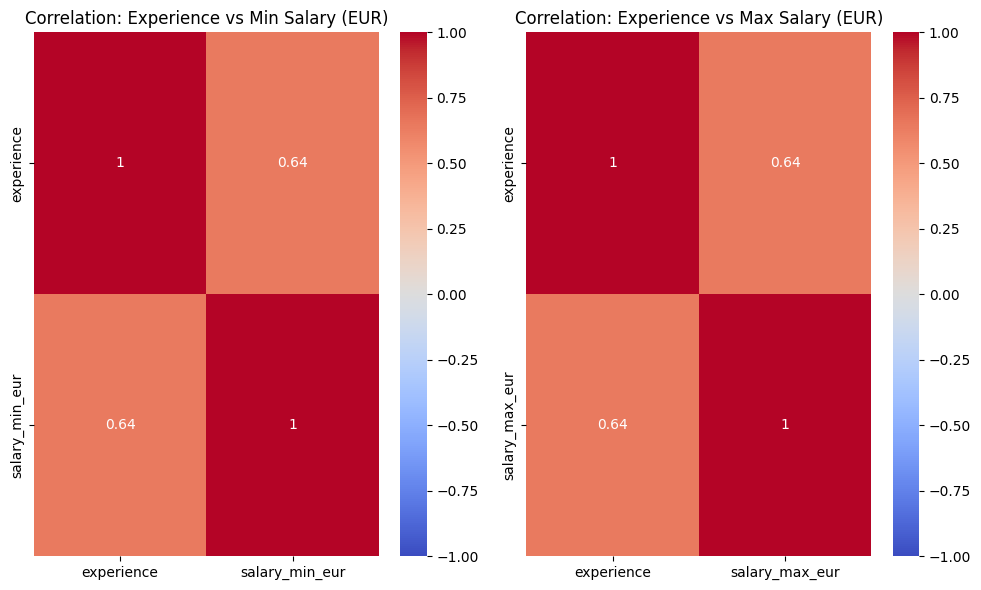

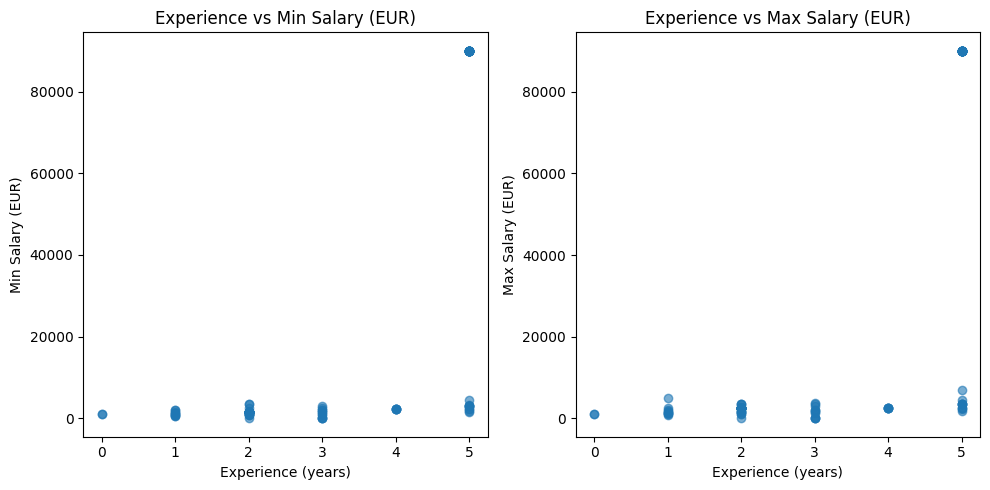

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where experience or salary (min or max) is missing
df_clean_corr = df.dropna(subset=['experience', 'salary_min_eur', 'salary_max_eur'])

# Compute correlation between experience and salaries
correlation_min = df_clean_corr[['experience', 'salary_min_eur']].corr()
correlation_max = df_clean_corr[['experience', 'salary_max_eur']].corr()

# Display correlation matrices
print("Correlation between Experience and Minimum Salary (EUR):")
print(correlation_min)
print("\nCorrelation between Experience and Maximum Salary (EUR):")
print(correlation_max)

# Plot heatmaps of the correlation matrices
plt.figure(figsize=(10, 6))

# Heatmap: Experience vs Min Salary
plt.subplot(1, 2, 1)
sns.heatmap(correlation_min, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation: Experience vs Min Salary (EUR)")

# Heatmap: Experience vs Max Salary
plt.subplot(1, 2, 2)
sns.heatmap(correlation_max, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation: Experience vs Max Salary (EUR)")

plt.tight_layout()
plt.show()

# Scatter plots for visual inspection
plt.figure(figsize=(10, 5))

# Scatter plot: Experience vs Min Salary
plt.subplot(1, 2, 1)
plt.scatter(df_clean_corr['experience'], df_clean_corr['salary_min_eur'], alpha=0.6)
plt.title("Experience vs Min Salary (EUR)")
plt.xlabel('Experience (years)')
plt.ylabel('Min Salary (EUR)')

# Scatter plot: Experience vs Max Salary
plt.subplot(1, 2, 2)
plt.scatter(df_clean_corr['experience'], df_clean_corr['salary_max_eur'], alpha=0.6)
plt.title("Experience vs Max Salary (EUR)")
plt.xlabel('Experience (years)')
plt.ylabel('Max Salary (EUR)')

plt.tight_layout()
plt.show()

## Salary and number of skills

Correlation Matrix (Average Salary vs Number of Skills):

                 salary_avg_eur  num_hard_skills  num_soft_skills
salary_avg_eur         1.000000         0.430322        -0.131638
num_hard_skills        0.430322         1.000000         0.356865
num_soft_skills       -0.131638         0.356865         1.000000


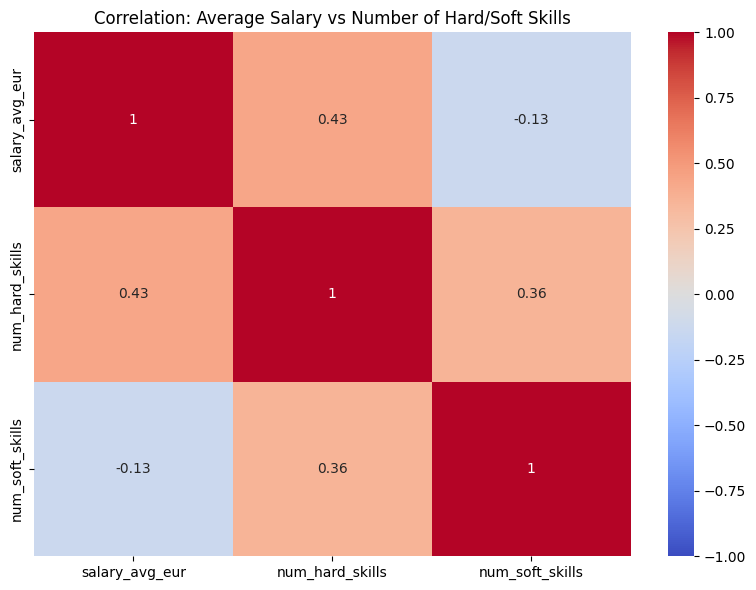

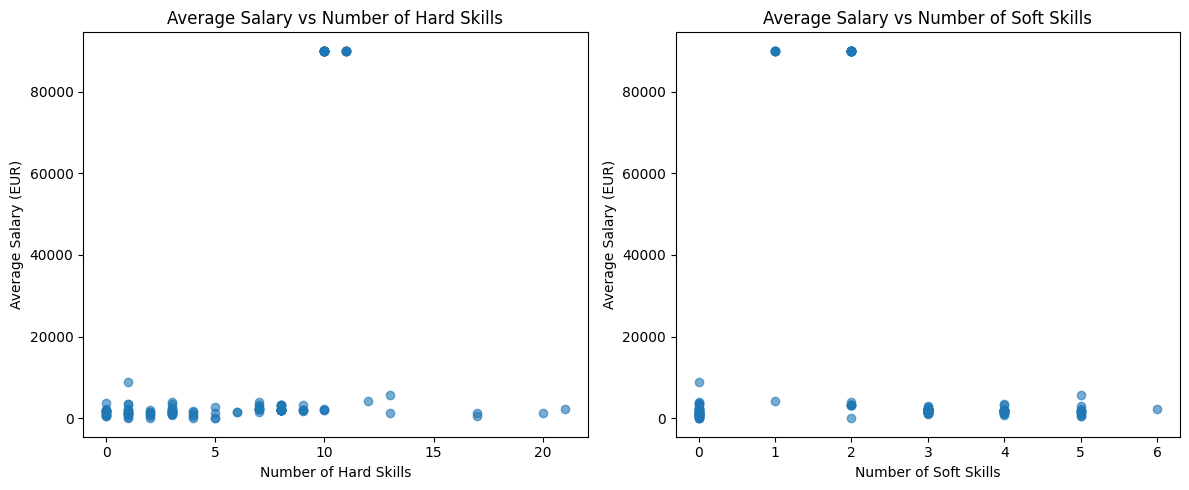

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `df` is already loaded and has `salary_min_eur` and `salary_max_eur` from your previous code

# 1. Calculate average salary (mean of min and max salaries)
df['salary_avg_eur'] = df[['salary_min_eur', 'salary_max_eur']].mean(axis=1)

# 2. Count the number of hard and soft skills
df['num_hard_skills'] = df['hard_skills'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df['num_soft_skills'] = df['soft_skills'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# 3. Filter out rows where salary_avg_eur is NaN
df_clean_skills = df.dropna(subset=['salary_avg_eur'])

# 4. Calculate correlations between average salary and number of skills
correlation_skills = df_clean_skills[['salary_avg_eur', 'num_hard_skills', 'num_soft_skills']].corr()

# Print the correlation matrix
print("Correlation Matrix (Average Salary vs Number of Skills):\n")
print(correlation_skills)

# 5. Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_skills, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation: Average Salary vs Number of Hard/Soft Skills')
plt.tight_layout()
plt.show()

# 6. Plot scatter plots for better visual understanding
plt.figure(figsize=(12, 5))

# Scatter plot for Average Salary vs Number of Hard Skills
plt.subplot(1, 2, 1)
plt.scatter(df_clean_skills['num_hard_skills'], df_clean_skills['salary_avg_eur'], alpha=0.6)
plt.title('Average Salary vs Number of Hard Skills')
plt.xlabel('Number of Hard Skills')
plt.ylabel('Average Salary (EUR)')

# Scatter plot for Average Salary vs Number of Soft Skills
plt.subplot(1, 2, 2)
plt.scatter(df_clean_skills['num_soft_skills'], df_clean_skills['salary_avg_eur'], alpha=0.6)
plt.title('Average Salary vs Number of Soft Skills')
plt.xlabel('Number of Soft Skills')
plt.ylabel('Average Salary (EUR)')

plt.tight_layout()
plt.show()


## Expected experience and number of skills

Correlation Matrix (Experience vs Number of Skills):

                 experience  num_hard_skills  num_soft_skills
experience         1.000000         0.131192         0.050859
num_hard_skills    0.131192         1.000000         0.182097
num_soft_skills    0.050859         0.182097         1.000000


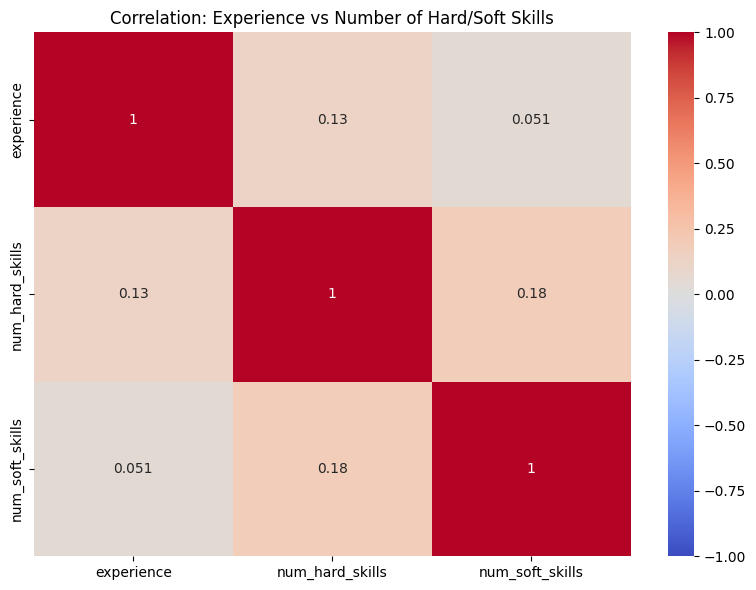

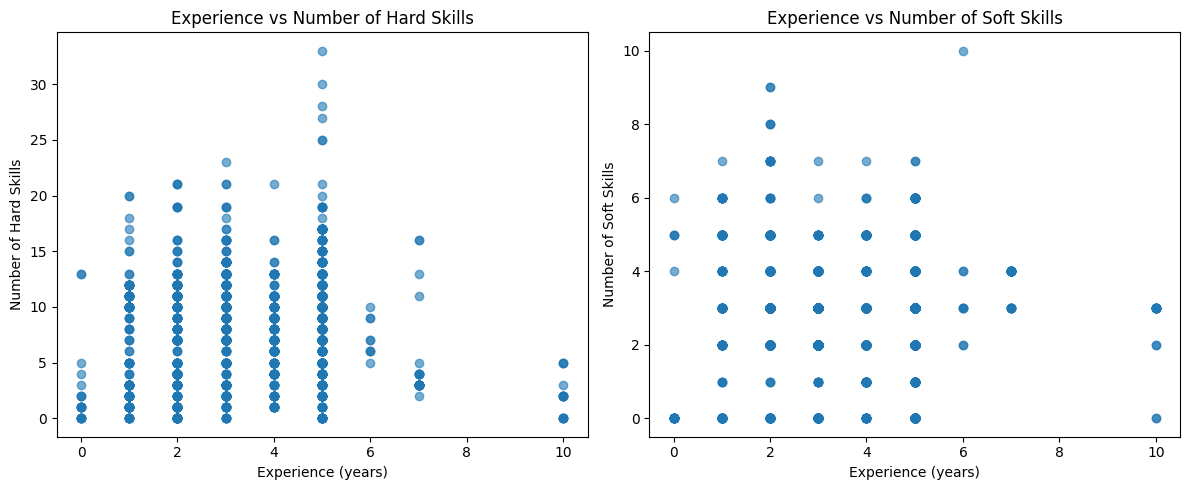

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `df` is already loaded

# Clean rows with NaN in 'experience', 'hard_skills', or 'soft_skills' and create a copy
df_clean_skills_exp = df.dropna(subset=['experience', 'hard_skills', 'soft_skills']).copy()

# Count the number of hard and soft skills
df_clean_skills_exp['num_hard_skills'] = df_clean_skills_exp['hard_skills'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_clean_skills_exp['num_soft_skills'] = df_clean_skills_exp['soft_skills'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Calculate correlations between experience and number of skills
correlation_exp_skills = df_clean_skills_exp[['experience', 'num_hard_skills', 'num_soft_skills']].corr()

# Print the correlation matrix
print("Correlation Matrix (Experience vs Number of Skills):\n")
print(correlation_exp_skills)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_exp_skills, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation: Experience vs Number of Hard/Soft Skills')
plt.tight_layout()
plt.show()

# Plot scatter plots for better visual understanding
plt.figure(figsize=(12, 5))

# Scatter plot for Experience vs Number of Hard Skills
plt.subplot(1, 2, 1)
plt.scatter(df_clean_skills_exp['experience'], df_clean_skills_exp['num_hard_skills'], alpha=0.6)
plt.title('Experience vs Number of Hard Skills')
plt.xlabel('Experience (years)')
plt.ylabel('Number of Hard Skills')

# Scatter plot for Experience vs Number of Soft Skills
plt.subplot(1, 2, 2)
plt.scatter(df_clean_skills_exp['experience'], df_clean_skills_exp['num_soft_skills'], alpha=0.6)
plt.title('Experience vs Number of Soft Skills')
plt.xlabel('Experience (years)')
plt.ylabel('Number of Soft Skills')

plt.tight_layout()
plt.show()


# Skill coocurences

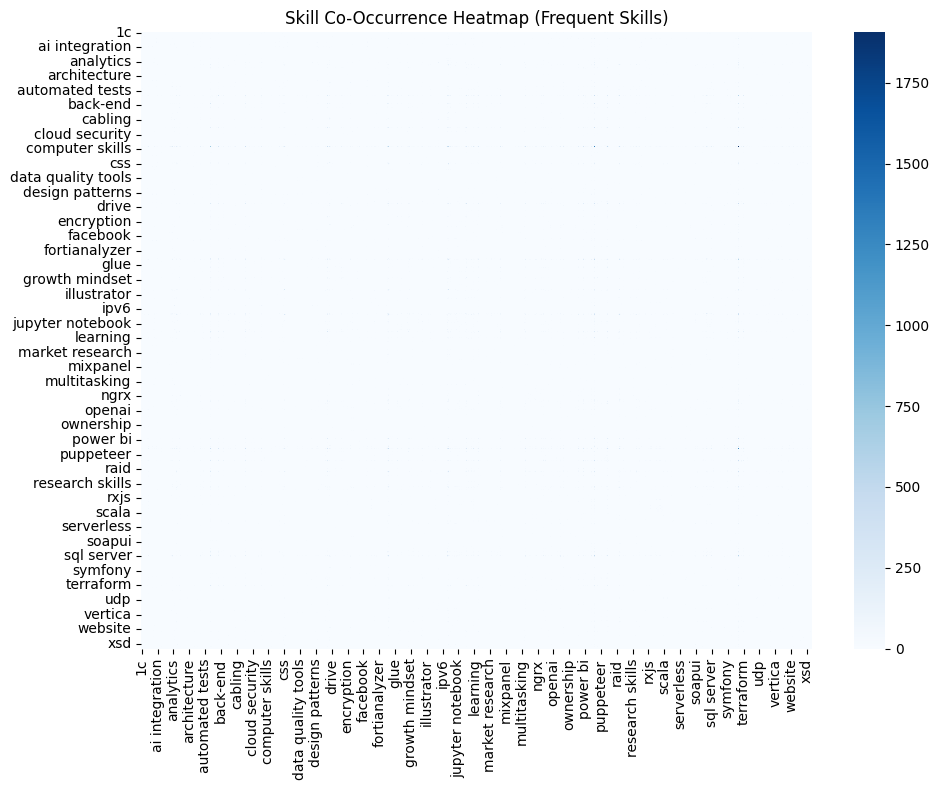

Top Skill Co-Occurrences:
communication & teamwork: 1906 jobs
problem solving & teamwork: 1279 jobs
communication & problem solving: 1276 jobs
aws & communication: 732 jobs
communication & sql: 681 jobs
aws & teamwork: 599 jobs
git & teamwork: 593 jobs
sql & teamwork: 581 jobs
communication & git: 554 jobs
communication & javascript: 509 jobs
communication & python: 495 jobs
git & problem solving: 489 jobs
problem solving & sql: 485 jobs
docker & teamwork: 476 jobs
aws & problem solving: 452 jobs
python & teamwork: 442 jobs
cicd & teamwork: 440 jobs
communication & java: 438 jobs
javascript & teamwork: 434 jobs
communication & docker: 420 jobs
cicd & communication: 406 jobs
communication & react: 385 jobs
react & teamwork: 385 jobs
postgresql & teamwork: 371 jobs
cicd & problem solving: 365 jobs
java & teamwork: 354 jobs
javascript & problem solving: 351 jobs
problem solving & python: 335 jobs
communication & postgresql: 332 jobs
azure & communication: 332 jobs
docker & problem solving

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Assuming df is already loaded
# Flatten all skills (hard + soft) into a single list per job
df['all_skills'] = df['hard_skills'] + df['soft_skills']

# Step 1: Collect unique skills incrementally and count frequencies
skill_counts = {}
for skills in df['all_skills']:
    for skill in skills:
        skill_counts[skill] = skill_counts.get(skill, 0) + 1

# Step 2: Filter skills appearing in at least 3 jobs
min_appearances = 3
frequent_skills = [skill for skill, count in skill_counts.items() if count >= min_appearances]
frequent_skills.sort()  # Sort for consistent ordering
skill_to_idx = {skill: idx for idx, skill in enumerate(frequent_skills)}

# Step 3: Create co-occurrence matrix using numpy
n_skills = len(frequent_skills)
co_occurrence_np = np.zeros((n_skills, n_skills), dtype=int)
for skills in df['all_skills']:
    # Only consider frequent skills
    job_skills = [skill for skill in skills if skill in skill_to_idx]
    skill_indices = [skill_to_idx[skill] for skill in job_skills]
    for i, j in combinations(skill_indices, 2):
        co_occurrence_np[i, j] += 1
        co_occurrence_np[j, i] += 1

# Convert to DataFrame for plotting
co_occurrence = pd.DataFrame(co_occurrence_np, index=frequent_skills, columns=frequent_skills)

# Step 4: Visualize as a heatmap
plt.figure(figsize=(10, 8))
annot = len(frequent_skills) <= 15
sns.heatmap(co_occurrence, cmap='Blues', annot=annot, fmt='d')
plt.title('Skill Co-Occurrence Heatmap (Frequent Skills)')
plt.tight_layout()
plt.show()

# Step 5: Alternative visualization - Bar chart of top co-occurrences
co_occurrence_stack = co_occurrence.where(np.triu(np.ones(co_occurrence.shape), k=1).astype(bool)).stack()
top_co_occurrences = co_occurrence_stack[co_occurrence_stack > 0].sort_values(ascending=False).head(50)

# Print top co-occurrences
print("Top Skill Co-Occurrences:")
for (skill1, skill2), count in top_co_occurrences.items():
    print(f"{skill1} & {skill2}: {int(count)} jobs")